In [2]:
!pip install nest_asyncio

In [3]:

import nest_asyncio
nest_asyncio.apply()

In [18]:
# AAS project will go here
import sys
import datetime
from netaddr import IPNetwork, IPAddress, IPSet
import pyshark

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
async def pktHandler(timestamp,srcIP,dstIP,lengthIP,sampDelta,outfile):
    global scnets
    global ssnets
    global npkts
    global T0
    global outc
    global last_ks
    
    if (IPAddress(srcIP) in scnets and IPAddress(dstIP) in ssnets) or (IPAddress(srcIP) in ssnets and IPAddress(dstIP) in scnets):
        if npkts==0:
            T0=float(timestamp)
            last_ks=0
            
        ks=int((float(timestamp)-T0)/sampDelta)
        
        if ks>last_ks:
            outfile.write('{} {} {} {} {}\n'.format(last_ks,*outc))
            #print('{} {} {} {} {}'.format(last_ks,*outc))
            outc=[0,0,0,0]  
            
        if ks>last_ks+1:
            for j in range(last_ks+1,ks):
                outfile.write('{} {} {} {} {}\n'.format(j,*outc))
                #print('{} {} {} {} {}'.format(j,*outc))
                  
        
        if IPAddress(srcIP) in scnets: #Upload
            outc[0]=outc[0]+1
            outc[1]=outc[1]+int(lengthIP)

        if IPAddress(dstIP) in scnets: #Download
            outc[2]=outc[2]+1
            outc[3]=outc[3]+int(lengthIP)
        
        last_ks=ks
        npkts=npkts+1

In [95]:
# code from basePktSampling
# Pcket sampling


# Clean data (Training Data)
# ------Variables go here-------
CNETS="172.16.183.0/24" # client (src)
sampDelta=1
SNETS="0.0.0.0/0" # service (dest)
fileOutput="sampled_data/clean_data.dat"
fileInput="data/cleanest_dset.pcapng"
#--------------------------------


cnets=[]
nn=IPNetwork(CNETS)
cnets.append(nn)

global scnets
scnets=IPSet(cnets)

snets=[]
nn=IPNetwork(SNETS)
snets.append(nn)

global ssnets
ssnets=IPSet(snets)

global npkts
global T0
global outc
global last_ks

npkts=0
outc=[0,0,0,0]

outfile = open(fileOutput,'w')

capture = pyshark.FileCapture(fileInput,display_filter='ip')
for pkt in capture:
    timestamp,srcIP,dstIP,lengthIP=pkt.sniff_timestamp,pkt.ip.src,pkt.ip.dst,pkt.ip.len
    await pktHandler(timestamp,srcIP,dstIP,lengthIP,sampDelta,outfile)

outfile.close()

step_name="packet sampling"
# interval up_pack up_bytes down_pack down_bytes

In [96]:
# Infected data (Validation Data)
# Pcket sampling

# ------Variables go here-------
CNETS="172.17.0.0/24" # client (src)
sampDelta=1
SNETS="0.0.0.0/0" # service (dest)
fileOutput="sampled_data/val_data.dat"
fileInput="data/val_data.pcapng"
#--------------------------------


cnets=[]
nn=IPNetwork(CNETS)
cnets.append(nn)

global scnets
scnets=IPSet(cnets)

snets=[]
nn=IPNetwork(SNETS)
snets.append(nn)

global ssnets
ssnets=IPSet(snets)

global npkts
global T0
global outc
global last_ks

npkts=0
outc=[0,0,0,0]

outfile = open(fileOutput,'w') 

capture = pyshark.FileCapture(fileInput,display_filter='ip')
for pkt in capture:
    timestamp,srcIP,dstIP,lengthIP=pkt.sniff_timestamp,pkt.ip.src,pkt.ip.dst,pkt.ip.len
    await pktHandler(timestamp,srcIP,dstIP,lengthIP,sampDelta,outfile)

outfile.close()

# interval up_pack up_bytes down_pack down_bytes

In [23]:
# InfectedMix data (Test Data)
# Pcket sampling

# ------Variables go here-------
CNETS="192.168.31.132" # client (src)
sampDelta=1
SNETS="0.0.0.0/0" # service (dest)
fileOutput="sampled_data/test_data.dat"
fileInput="data/test_data.pcapng"
#--------------------------------


cnets=[]
nn=IPNetwork(CNETS)
cnets.append(nn)

global scnets
scnets=IPSet(cnets)

snets=[]
nn=IPNetwork(SNETS)
snets.append(nn)

global ssnets
ssnets=IPSet(snets)

global npkts
global T0
global outc
global last_ks

npkts=0
outc=[0,0,0,0]

outfile = open(fileOutput,'w') 

capture = pyshark.FileCapture(fileInput,display_filter='ip')
for pkt in capture:
    timestamp,srcIP,dstIP,lengthIP=pkt.sniff_timestamp,pkt.ip.src,pkt.ip.dst,pkt.ip.len
    await pktHandler(timestamp,srcIP,dstIP,lengthIP,sampDelta,outfile)

outfile.close()

# interval up_pack up_bytes down_pack down_bytes

In [19]:
# Total values

def showChart(clean_data,infected_data,name:str="placeholder"):
        print(clean_data.shape)
        print(infected_data.shape)
        diff = clean_data.shape[0]-infected_data.shape[0]
        if diff<0:
            print(clean_data.shape)
            clean_data= np.pad(clean_data, ((0,diff),(0, 0)), 
                                  mode="constant")
            print(clean_data.shape)
            
        if diff>0:
            print(infected_data.shape)
            infected_data= np.pad(infected_data, ((0,diff),(0, 0)), 
                                  mode="constant")
            print(infected_data.shape)
        print(name)
        plt.figure(figsize=(15,15))
        plt.subplot(2,1,1)
        plt.plot(clean_data[:,1],infected_data[:,1])
        plt.xlabel('Time (s)')
        plt.ylabel('Nº of Packets (Upload)')
        plt.legend()

        plt.subplot(2,1,2)
        plt.plot(clean_data[:,2],infected_data[:,2])
        plt.xlabel('Time (s)')
        plt.ylabel('Byte count (Upload)')
        plt.show()
        
def showChart_but_chatgpt_did_it_upload(clean_data, infected_data, name:str="placeholder"):
    diff = clean_data.shape[0] - infected_data.shape[0]
    if diff < 0:
        clean_data = np.pad(clean_data, ((0, diff), (0, 0)), mode="constant")
    elif diff > 0:
        infected_data = np.pad(infected_data, ((0, diff), (0, 0)), mode="constant")
    
    plt.figure(figsize=(15, 15))
    plt.subplot(2,1,1)
    plt.plot(infected_data[:, 1], label="infected data")
    plt.plot(clean_data[:, 1], label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Nº of Packets')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(infected_data[:, 2], label="infected data")
    plt.plot(clean_data[:, 2], label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.suptitle("Upload")
    plt.show()

def showChart_but_chatgpt_did_it_download(clean_data, infected_data, name:str="placeholder"):
    diff = clean_data.shape[0] - infected_data.shape[0]
    if diff < 0:
        clean_data = np.pad(clean_data, ((0, diff), (0, 0)), mode="constant")
    elif diff > 0:
        infected_data = np.pad(infected_data, ((0, diff), (0, 0)), mode="constant")

    plt.figure(figsize=(15, 15))
    plt.subplot(2,1,1)
    plt.plot(infected_data[:, 3], label="infected data")
    plt.plot(clean_data[:, 3], label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Nº of Packets')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(infected_data[:, 4], label="infected data")
    plt.plot(clean_data[:, 4], label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.suptitle("Download")

    plt.show()


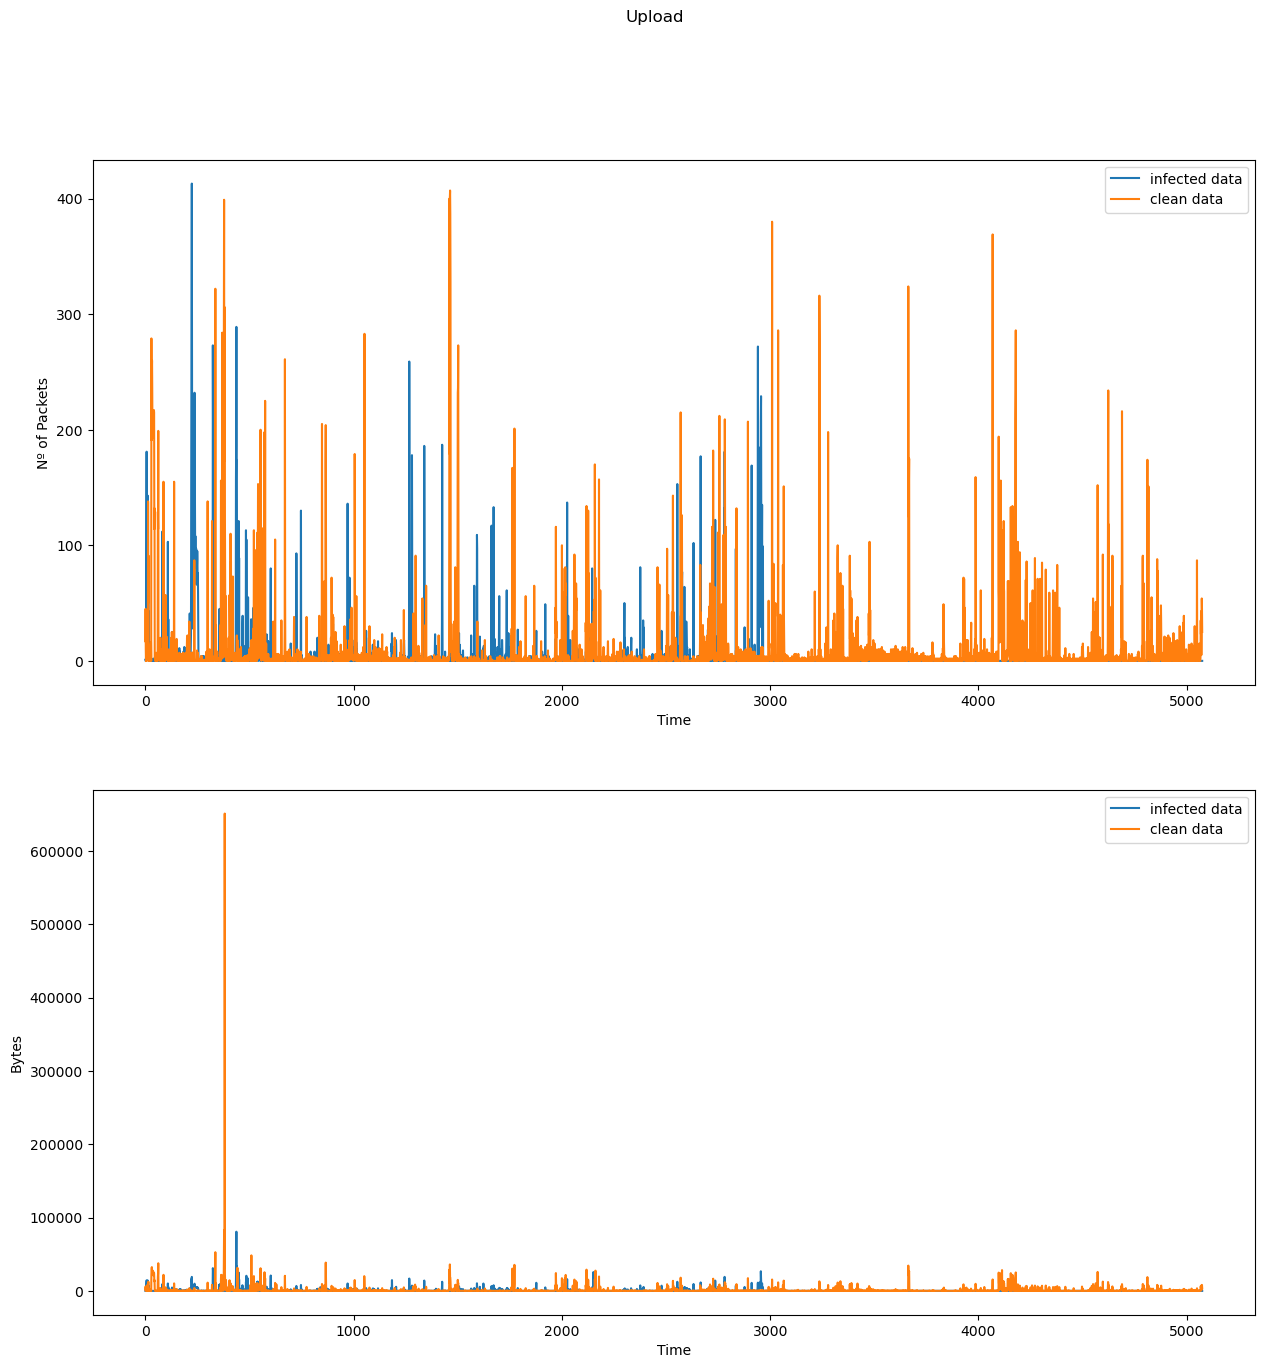

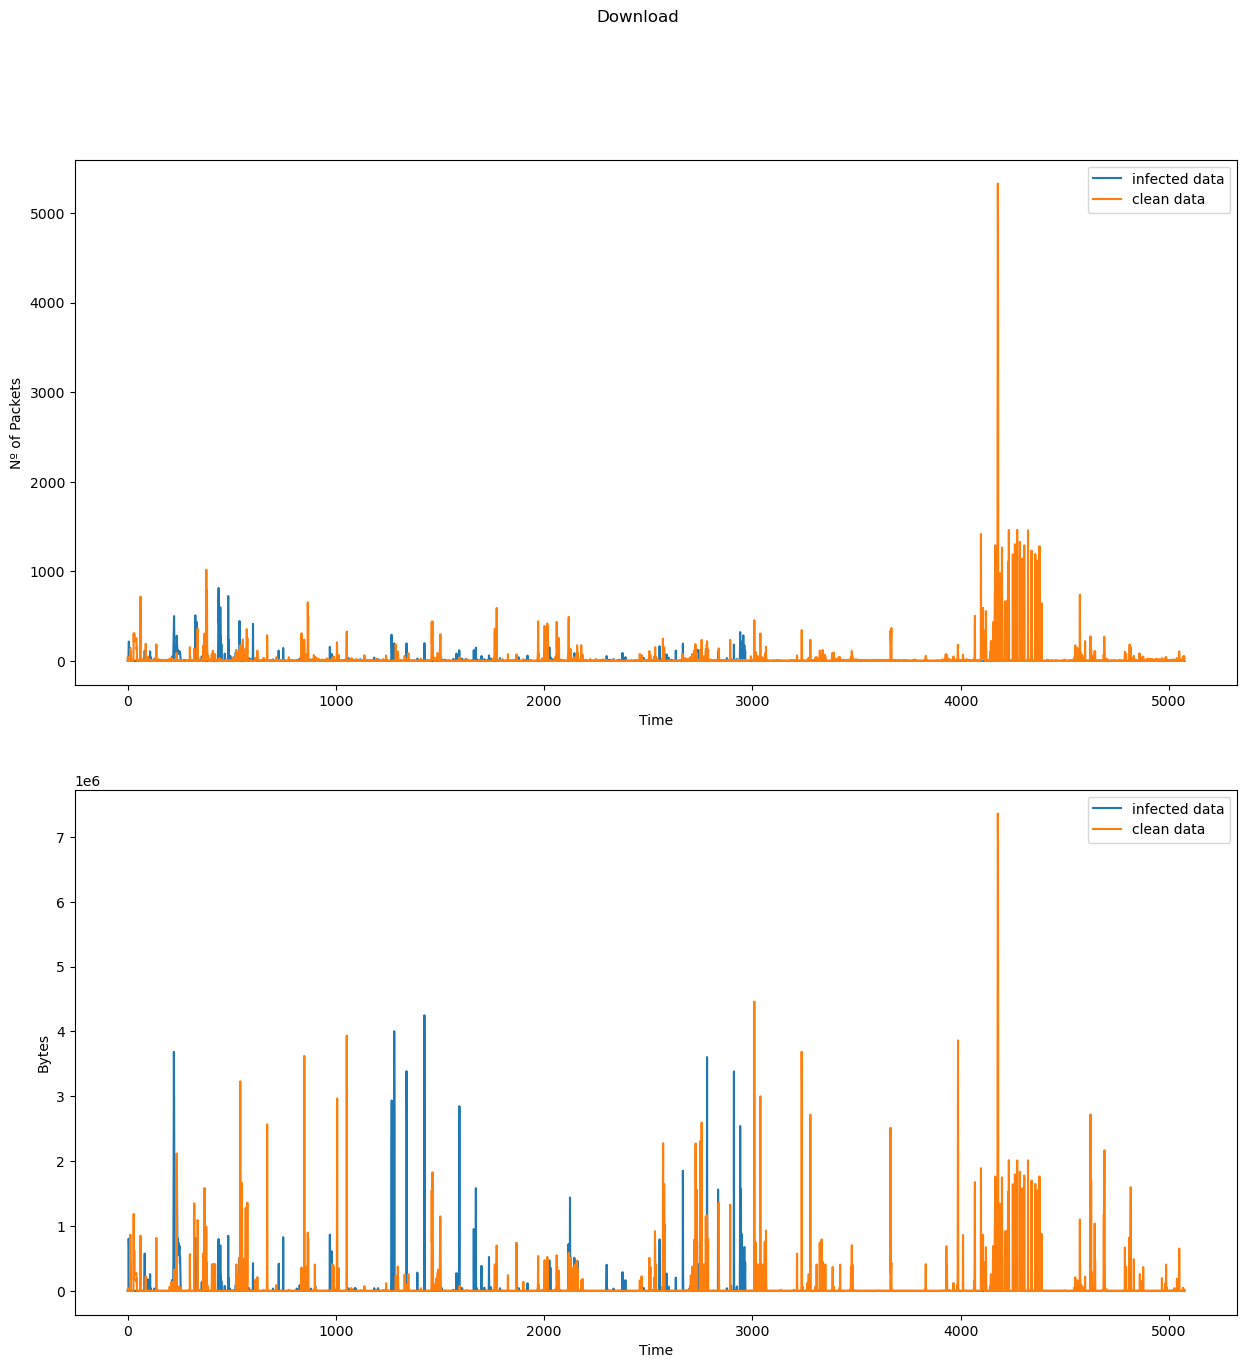

In [81]:
clean_data=np.loadtxt("sampled_data/clean_data.dat",dtype=int)
infected_data=np.loadtxt("sampled_data/test_data.dat",dtype=int)
infected_data = infected_data[:2966,:] # trim anomalous end
showChart_but_chatgpt_did_it_upload(clean_data,infected_data,"Upload")
showChart_but_chatgpt_did_it_download(clean_data,infected_data,"Download")


In [131]:
# Bytes over packets
def showChart_upload_ratio(clean_data, infected_data, name:str="placeholder"):
    diff = clean_data.shape[0] - infected_data.shape[0]
    if diff < 0:
        clean_data = np.pad(clean_data, ((0, diff), (0, 0)), mode="constant")
    elif diff > 0:
        infected_data = np.pad(infected_data, ((0, diff), (0, 0)), mode="constant")
    
    # Calculate the average number of bytes per packet for each row
    clean_avg_bytes_per_packet =  [clean_data[x, 2] / clean_data[x, 1]  if clean_data[x,1]!=0 else 0 for x in range(clean_data.shape[0]) ]
    infected_avg_bytes_per_packet =[infected_data[x, 2] / infected_data[x, 1]  if infected_data[x,1]!=0 else 0 for x in range(infected_data.shape[0]) ]
 
    plt.figure(figsize=(15, 15))
    plt.subplot(2,1,1)
    plt.plot(infected_avg_bytes_per_packet, label="infected data")
    plt.plot(clean_avg_bytes_per_packet, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Nº of Packets')
    plt.title("Upload")
    plt.legend()

    
    clean_avg_bytes_per_packet =  [clean_data[x, 4] / clean_data[x, 3]  if clean_data[x,3]!=0 else 0 for x in range(clean_data.shape[0]) ]
    infected_avg_bytes_per_packet =[infected_data[x, 4] / infected_data[x, 3]  if infected_data[x,3]!=0 else 0 for x in range(infected_data.shape[0]) ]
 


    plt.subplot(2,1,2)
    plt.plot(clean_avg_bytes_per_packet, label="infected data")
    plt.plot(infected_avg_bytes_per_packet, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.title("Download")
    plt.suptitle("Bytes/Packets Ratio")
    plt.show()
    
    

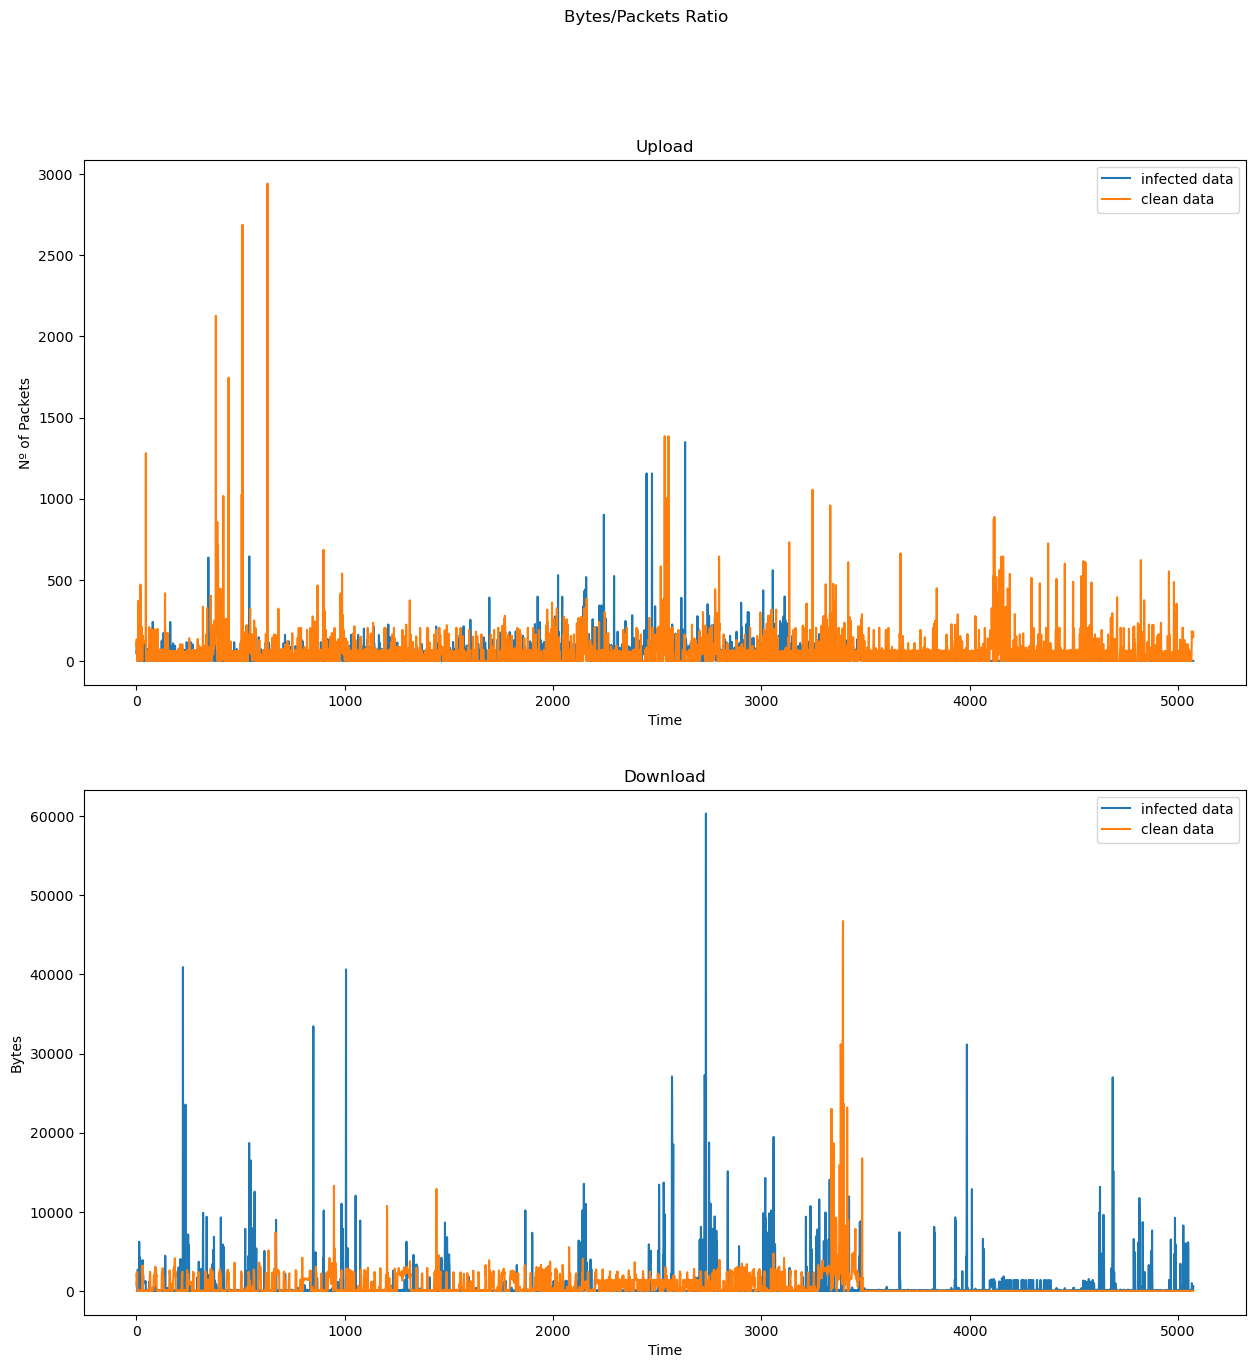

In [132]:
showChart_upload_ratio(clean_data,infected_data)


In [151]:
# Cumulative sum for evolution of packets/bytes

def showChart_bytes_csum(clean_data, infected_data, name:str="placeholder"):
    diff = clean_data.shape[0] - infected_data.shape[0]
    if diff < 0:
        clean_data = np.pad(clean_data, ((0, diff), (0, 0)), mode="constant")
    elif diff > 0:
        infected_data = np.pad(infected_data, ((0, diff), (0, 0)), mode="constant")
    
    # Calculate the average number of bytes per packet for each row
    clean_cumulative_bytes_sent = np.cumsum(clean_data[:, 2])
    infected_cumulative_bytes_sent = np.cumsum(infected_data[:, 2]) 
    plt.figure(figsize=(15, 15))
    plt.subplot(2,1,1)
    plt.plot(infected_cumulative_bytes_sent, label="infected data")
    plt.plot(clean_cumulative_bytes_sent, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.title("Upload")
    plt.legend()

    
    clean_cumulative_bytes_sent = np.cumsum(clean_data[:, 4])
    infected_cumulative_bytes_sent = np.cumsum(infected_data[:, 4]) 
 


    plt.subplot(2,1,2)
    plt.plot(infected_cumulative_bytes_sent, label="infected data")
    plt.plot(clean_cumulative_bytes_sent, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.title("Download")
    plt.suptitle("Total Bytes Sent/Received")
    plt.show()

def showChart_packets_csum(clean_data, infected_data, name:str="placeholder"):
    diff = clean_data.shape[0] - infected_data.shape[0]
    if diff < 0:
        clean_data = np.pad(clean_data, ((0, diff), (0, 0)), mode="constant")
    elif diff > 0:
        infected_data = np.pad(infected_data, ((0, diff), (0, 0)), mode="constant")
    
    # Calculate the average number of bytes per packet for each row
    clean_cumulative_bytes_sent = np.cumsum(clean_data[:, 1])
    infected_cumulative_bytes_sent = np.cumsum(infected_data[:, 1]) 
    plt.figure(figsize=(15, 15))
    plt.subplot(2,1,1)
    plt.plot(infected_cumulative_bytes_sent, label="infected data")
    plt.plot(clean_cumulative_bytes_sent, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Packets')
    plt.title("Upload")
    plt.legend()

    
    clean_cumulative_bytes_sent = np.cumsum(clean_data[:, 3])
    infected_cumulative_bytes_sent = np.cumsum(infected_data[:, 3]) 
 


    plt.subplot(2,1,2)
    plt.plot(infected_cumulative_bytes_sent, label="infected data")
    plt.plot(clean_cumulative_bytes_sent, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Packets')
    plt.legend()
    plt.title("Download")
    plt.suptitle("Total Packets Sent/Received")
    plt.show()

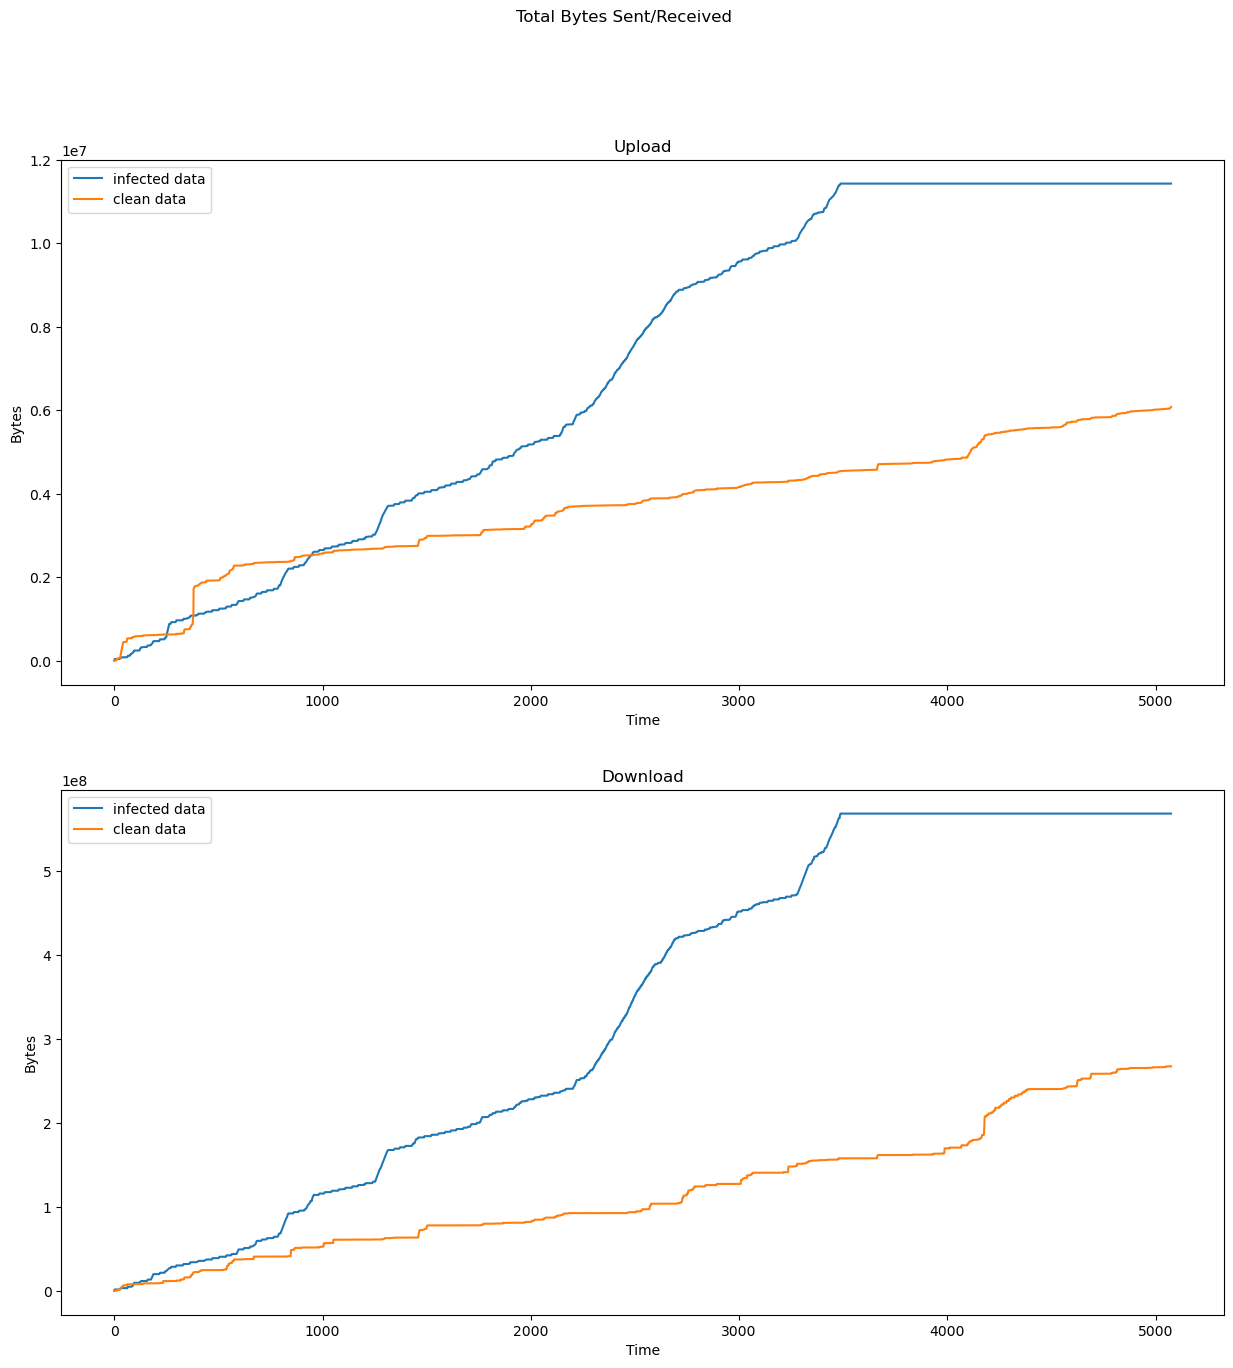

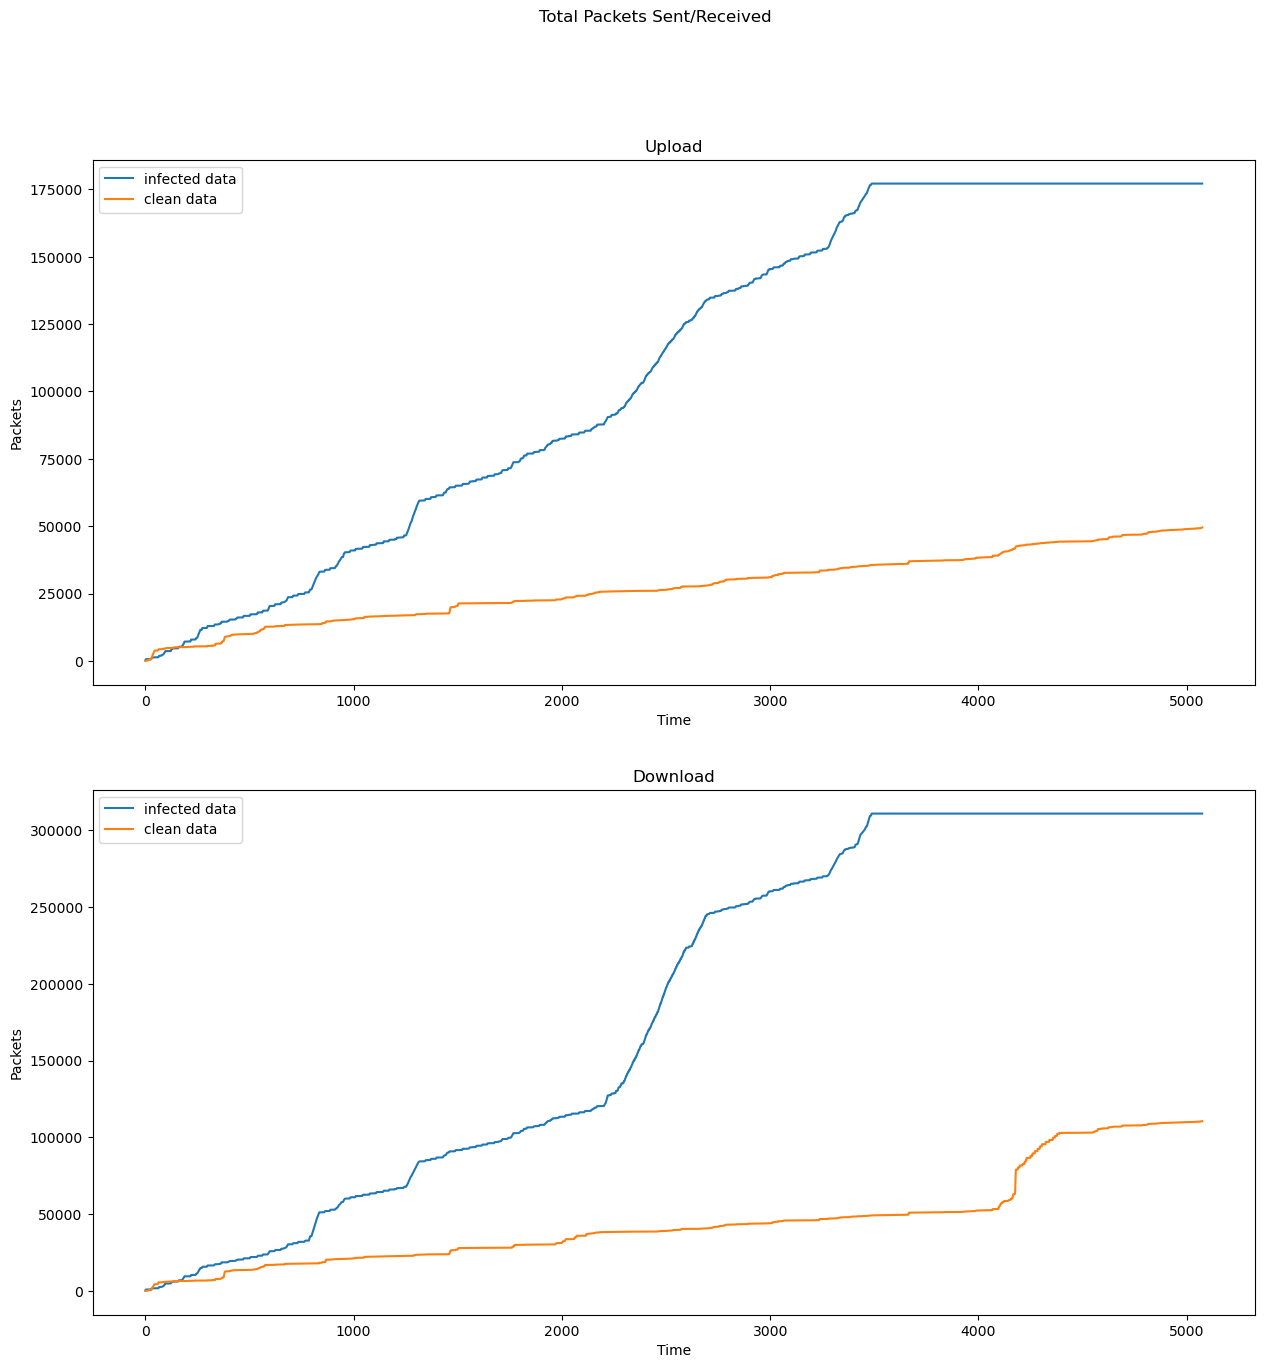

In [152]:
showChart_bytes_csum(clean_data,infected_data)
showChart_packets_csum(clean_data,infected_data)

In [97]:




# Add labels to data 

fileInput="sampled_data/clean_data.dat"
clean_data=np.loadtxt(fileInput,dtype=int)
clean_data=np.column_stack((clean_data,np.zeros((clean_data.shape[0],1))))
np.savetxt(fileInput,clean_data,fmt='%d')

fileInput="sampled_data/val_data.dat"
val_data=np.loadtxt(fileInput,dtype=int)
val_data=np.column_stack((val_data,np.zeros((val_data.shape[0],1))))

for i in range(val_data.shape[0]):
    if val_data[i][1]==0 and val_data[i][2]==0 and val_data[i][3]==0 and val_data[i][4]==0:
        pass
    else:
        val_data[i][5] = 1

        
    
    
print(val_data)   
np.savetxt(fileInput,val_data,fmt='%d')


[[0.0000e+00 1.1000e+01 1.9090e+03 1.1000e+01 5.9260e+03 1.0000e+00]
 [1.0000e+00 8.0000e+00 3.2000e+02 8.0000e+00 2.9731e+04 1.0000e+00]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [1.4500e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.4510e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.4520e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


In [99]:
num_rows = clean_data.shape[0]
result = np.pad(val_data, ((0, num_rows - val_data.shape[0]), (0, 0)), 'constant')

new_val_data= clean_data + result
np.savetxt(fileInput,new_val_data,fmt='%d')


In [100]:
# analyze with sliding window

import numpy as np
import matplotlib.pyplot as plt
import os

In [101]:
def slidingObsWindow(data,lengthObsWindow,slidingValue,basename):
    iobs=0
    nSamples,nMetrics=data.shape
    obsData=np.zeros((0,lengthObsWindow,nMetrics))
    for s in np.arange(lengthObsWindow,nSamples,slidingValue):
        subdata=data[s-lengthObsWindow:s,:]
        obsData=np.insert(obsData,iobs,subdata,axis=0)

        obsFname="{}_obs{}_w{}.dat".format(basename,iobs,lengthObsWindow)
        iobs+=1
        np.savetxt(obsFname,subdata,fmt='%d')

    return obsData # 3D arrays (obs, sample, metric)

In [102]:
fileInput="sampled_data/clean_data.dat"
lengthObsWindow=[15]
slidingValue=3

data=np.loadtxt(fileInput,dtype=int)
fname=''.join(fileInput.split('.')[:-1])
basename="obs/clean_data/"

obsData=slidingObsWindow(data,lengthObsWindow[0],slidingValue,basename)


In [103]:
# val obs samples
fileInput="sampled_data/val_data.dat"
lengthObsWindow=[15]
slidingValue=3

data=np.loadtxt(fileInput,dtype=int)
fname=''.join(fileInput.split('.')[:-1])
basename="obs/val_data/"
obsData=slidingObsWindow(data,lengthObsWindow[0],slidingValue,basename)


In [104]:
# test obs samples
fileInput="sampled_data/test_data.dat"
lengthObsWindow=[15]
slidingValue=3

data=np.loadtxt(fileInput,dtype=int)
fname=''.join(fileInput.split('.')[:-1])
basename="obs/test_data/"
obsData=slidingObsWindow(data,lengthObsWindow[0],slidingValue,basename)


In [105]:
# Extract Features
import argparse
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from baseObsWindows import slidingMultObsWindow
import os

def extractFeatures(dirname,basename,nObs,allwidths):
    for o in range(0,nObs):
        features=np.array([])
        label = 0
        for oW in allwidths:
            obsfilename=dirname+"/"+basename+str(o)+"_w"+str(oW)+".dat"
            # print(obsfilename)
            subdata=np.loadtxt(obsfilename)[:,1:]    #Loads data and removes first column (sample index)
            # removes last column (labels)
            labels = subdata[:,-1:]
            for lb in labels:
                if lb==1:
                    label = 1
                    break
            subdata=subdata[:,:-1]
            faux=extractStats(subdata)    
            features=np.hstack((features,faux))
            
            # faux2=extractStatsSilenceActivity(subdata)
            # features=np.hstack((features,faux2))
        features=np.append(features,label)
        if o==0:
            obsFeatures=features
        else:
            obsFeatures=np.vstack((obsFeatures,features))

    return obsFeatures


def extractStats(data):
    nSamp,nCols=data.shape

    M1=np.mean(data,axis=0)
    Md1=np.median(data,axis=0)
    Std1=np.std(data,axis=0)
    S1=stats.skew(data)
    #K1=stats.kurtosis(data)
    p=[75,90,95,98]
    Pr1=np.array(np.percentile(data,p,axis=0)).T.flatten()
        
    features=np.hstack((M1,Md1,Std1,S1,Pr1))
    return(features)


# 4 colunas (2*up+2*down) * (8 features + 6 do silence^(3*2)) 

# up_pack (0:media 1:mediana 2:std 3:skew 4:75p 5:90p 6:95p 7:98p //8:len(silence) 9:mean_silence 10:std_silence 11:len(activity) 12:mean_act 13:std_act) ) up_bytes


In [106]:
dirname="obs/clean_data"
allwidths=[15]

allfiles=os.listdir(dirname)
nObs=len([f for f in allfiles if '_w{}.'.format(allwidths[0]) in f])
lbn=allfiles[0].rfind("obs")+3
basename=allfiles[0][:lbn]

features=extractFeatures(dirname,basename,nObs,allwidths)

outfilename="features/clean_data/clean_features.dat"

np.savetxt(outfilename,features,fmt='%.4f')


In [107]:
dirname="obs/val_data"
allwidths=[15]

allfiles=os.listdir(dirname)
nObs=len([f for f in allfiles if '_w{}.'.format(allwidths[0]) in f])
lbn=allfiles[0].rfind("obs")+3
basename=allfiles[0][:lbn]

features=extractFeatures(dirname,basename,nObs,allwidths)

outfilename="features/val_data/val_features.dat"

np.savetxt(outfilename,features,fmt='%.4f')


In [179]:
import argparse
import scipy.stats as stats
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import scalogram
from baseObsWindows import slidingMultObsWindow
import os

def extractPeriodicityFeatures(dirname,basename,nObs,allwidths):
    for o in range(0,nObs):
        features=np.array([])
        for oW in allwidths:
            obsfilename=dirname+"/"+basename+str(o)+"_w"+str(oW)+".dat"
            #print(obsfilename)
            subdata=np.loadtxt(obsfilename)[:,1]    #Loads data, only second column
            
            scales=np.arange(2,50)                  
            S,scales=scalogram.scalogramCWT(subdata,scales)   #periodogram using CWT (Morlet wavelet)
            features=np.hstack((features,S))
            
            #f,psd=signal.periodogram(subdata)      #periodogram using the Welch's method
            #features=np.hstack((features,pad))
            
            #fft=np.fft.fft(subdata)                   #periodogram using basic modulus-squared of the discrete FFT
            #psd=abs(fft)**2
            #features=np.hstack((features,psd))
            
        if o==0:
            obsFeatures=features
        else:
            obsFeatures=np.vstack((obsFeatures,features))

    return obsFeatures

def slidingObsWindow(data,lengthObsWindow,slidingValue,basename):
    iobs=0
    nSamples,nMetrics=data.shape
    obsData=np.zeros((0,lengthObsWindow,nMetrics))
    for s in np.arange(lengthObsWindow,nSamples,slidingValue):
        subdata=data[s-lengthObsWindow:s,:]
        obsData=np.insert(obsData,iobs,subdata,axis=0)
        
        obsFname="{}_obs{}_w{}.dat".format(basename,iobs,lengthObsWindow)
        iobs+=1
        np.savetxt(obsFname,subdata,fmt='%.4f')
               
    return obsData # 3D arrays (obs, sample, metric)


[2.94360000e+03 1.88533300e+02 3.02667000e+01 3.29333000e+01
 2.76000000e+01 1.53266670e+03 2.54113330e+03 2.55086670e+03
 2.55306670e+03 2.87413330e+03 1.34900000e+03 3.50266700e+02
 3.56066700e+02 3.60933300e+02 4.47333000e+01 5.44000000e+01
 1.71533300e+02 1.70986670e+03 2.46240000e+03 2.46726670e+03
 2.46240000e+03 3.85653330e+03 2.84766670e+03 3.42666670e+03
 4.02313330e+03 4.81473330e+03 4.18173330e+03 6.02706670e+03
 4.78446670e+03 4.18093330e+03 3.39246670e+03 2.50980000e+03
 1.24800000e+02 3.41333000e+01 3.14667000e+01 2.93333000e+01
 5.38066700e+02 3.37146670e+03 4.75293330e+03 5.27060000e+03
 5.27326670e+03 4.91886670e+03 2.09340000e+03 7.13800000e+02
 2.06800000e+02 2.08933300e+02 5.76667000e+01 5.72667000e+01
 1.18660000e+03 2.51486670e+03 2.73706670e+03 2.73400000e+03
 2.74440000e+03 1.61240000e+03 1.01053330e+03 1.98426670e+03
 3.00506670e+03 4.55366670e+03 6.68400000e+03 5.94960000e+03
 4.77580000e+03 3.77886670e+03 2.21473330e+03 8.17333000e+01
 8.39333000e+01 5.700000

[3.41333000e+01 3.14667000e+01 2.93333000e+01 5.38066700e+02
 3.37146670e+03 4.75293330e+03 5.27060000e+03 5.27326670e+03
 4.91886670e+03 2.09340000e+03 7.13800000e+02 2.06800000e+02
 2.08933300e+02 5.76667000e+01 5.72667000e+01 1.18660000e+03
 2.51486670e+03 2.73706670e+03 2.73400000e+03 2.74440000e+03
 1.61240000e+03 1.01053330e+03 1.98426670e+03 3.00506670e+03
 4.55366670e+03 6.68400000e+03 5.94960000e+03 4.77580000e+03
 3.77886670e+03 2.21473330e+03 8.17333000e+01 8.39333000e+01
 5.70000000e+01 3.62000000e+01 2.84667000e+01 1.88753330e+03
 2.87120000e+03 2.86053330e+03 2.86013330e+03 2.87073330e+03
 1.01166670e+03 3.94667000e+01 5.01333000e+01 1.20086670e+03
 2.45166670e+03 3.10626670e+03 5.72946670e+03 1.02449333e+04
 1.34264667e+04 1.64137333e+04 2.03053333e+04 1.88517333e+04
 1.43309333e+04 1.14425333e+04 8.54800000e+03 3.99993330e+03
 2.81666670e+03 2.81133330e+03 1.36740000e+03 2.34000000e+01
 3.59333000e+01 9.71200000e+02 2.90913330e+03 2.90913330e+03
 2.91120000e+03 2.896000

[3.62000000e+01 2.84667000e+01 1.88753330e+03 2.87120000e+03
 2.86053330e+03 2.86013330e+03 2.87073330e+03 1.01166670e+03
 3.94667000e+01 5.01333000e+01 1.20086670e+03 2.45166670e+03
 3.10626670e+03 5.72946670e+03 1.02449333e+04 1.34264667e+04
 1.64137333e+04 2.03053333e+04 1.88517333e+04 1.43309333e+04
 1.14425333e+04 8.54800000e+03 3.99993330e+03 2.81666670e+03
 2.81133330e+03 1.36740000e+03 2.34000000e+01 3.59333000e+01
 9.71200000e+02 2.90913330e+03 2.90913330e+03 2.91120000e+03
 2.89600000e+03 1.95806670e+03 2.01333000e+01 1.22000000e+01
 0.00000000e+00 4.53330000e+00 9.40000000e+00 1.42000000e+01
 1.94346670e+03 2.37160000e+03 2.36706670e+03 2.37706670e+03
 2.58380000e+03 7.50933300e+02 5.64866700e+02 1.18540000e+03
 1.55820000e+03 2.12346670e+03 2.02706670e+03 3.19260000e+03
 3.89700000e+03 3.52000000e+03 2.74320000e+03 2.86486670e+03
 1.47293330e+03 1.55200000e+02 1.44533300e+02 1.47200000e+02
 3.08667000e+01 7.61400000e+02 1.08566670e+03 1.45633330e+03
 2.82833330e+03 2.972333

[1.9580667e+03 2.0133300e+01 1.2200000e+01 0.0000000e+00 4.5333000e+00
 9.4000000e+00 1.4200000e+01 1.9434667e+03 2.3716000e+03 2.3670667e+03
 2.3770667e+03 2.5838000e+03 7.5093330e+02 5.6486670e+02 1.1854000e+03
 1.5582000e+03 2.1234667e+03 2.0270667e+03 3.1926000e+03 3.8970000e+03
 3.5200000e+03 2.7432000e+03 2.8648667e+03 1.4729333e+03 1.5520000e+02
 1.4453330e+02 1.4720000e+02 3.0866700e+01 7.6140000e+02 1.0856667e+03
 1.4563333e+03 2.8283333e+03 2.9723333e+03 2.2288000e+03 1.9208667e+03
 1.5581333e+03 1.8346670e+02 5.7933300e+01 6.0066700e+01 3.6533300e+01
 3.3933300e+01 1.1908000e+03 1.5856000e+03 2.2193333e+03 2.9792667e+03
 2.9788000e+03 1.8219333e+03 1.4086667e+03 7.7013330e+02 1.0200000e+01
 1.0666700e+01 1.8600000e+01 1.3266700e+01 1.2027333e+03 2.5343333e+03
 2.5561333e+03 2.5482000e+03 2.5579333e+03 1.3684667e+03 3.6866700e+01
 9.7333000e+00 1.7666700e+01 7.9333000e+00 7.9333000e+00 1.3910667e+03
 2.4351333e+03 2.4521333e+03 2.4521333e+03 2.4636000e+03 1.0953333e+03
 5.126

[2.2288000e+03 1.9208667e+03 1.5581333e+03 1.8346670e+02 5.7933300e+01
 6.0066700e+01 3.6533300e+01 3.3933300e+01 1.1908000e+03 1.5856000e+03
 2.2193333e+03 2.9792667e+03 2.9788000e+03 1.8219333e+03 1.4086667e+03
 7.7013330e+02 1.0200000e+01 1.0666700e+01 1.8600000e+01 1.3266700e+01
 1.2027333e+03 2.5343333e+03 2.5561333e+03 2.5482000e+03 2.5579333e+03
 1.3684667e+03 3.6866700e+01 9.7333000e+00 1.7666700e+01 7.9333000e+00
 7.9333000e+00 1.3910667e+03 2.4351333e+03 2.4521333e+03 2.4521333e+03
 2.4636000e+03 1.0953333e+03 5.1266700e+01 2.6333300e+01 5.6066700e+01
 2.4866670e+02 4.4946670e+02 7.4413330e+02 3.1075333e+03 3.1716667e+03
 2.9676000e+03 2.8632000e+03 2.5733333e+03 2.0993330e+02 1.4140000e+02
 1.4140000e+02 1.5918667e+03 2.5524667e+03 2.5524667e+03 2.5271333e+03
 2.5271333e+03 9.6540000e+02 0.0000000e+00 0.0000000e+00 4.9753330e+02
 2.3650000e+03 4.3221333e+03 5.7754667e+03 6.2022667e+03 5.7047333e+03
 3.8372667e+03 1.8801333e+03 4.2680000e+02 7.9333000e+00 7.9333000e+00
 2.594

[2.45213330e+03 2.45213330e+03 2.46360000e+03 1.09533330e+03
 5.12667000e+01 2.63333000e+01 5.60667000e+01 2.48666700e+02
 4.49466700e+02 7.44133300e+02 3.10753330e+03 3.17166670e+03
 2.96760000e+03 2.86320000e+03 2.57333330e+03 2.09933300e+02
 1.41400000e+02 1.41400000e+02 1.59186670e+03 2.55246670e+03
 2.55246670e+03 2.52713330e+03 2.52713330e+03 9.65400000e+02
 0.00000000e+00 0.00000000e+00 4.97533300e+02 2.36500000e+03
 4.32213330e+03 5.77546670e+03 6.20226670e+03 5.70473330e+03
 3.83726670e+03 1.88013330e+03 4.26800000e+02 7.93330000e+00
 7.93330000e+00 2.59400000e+02 2.57526670e+03 2.58540000e+03
 2.57746670e+03 2.57746670e+03 2.42206670e+03 1.06200000e+02
 9.60667000e+01 9.60667000e+01 9.60667000e+01 8.64333300e+02
 2.57240000e+03 2.57240000e+03 2.59800000e+03 2.99200000e+03
 2.53766670e+03 9.14933300e+02 1.34960000e+03 1.80126670e+03
 1.84993330e+03 2.76866670e+03 4.75860000e+03 5.34193330e+03
 4.86946670e+03 4.42680000e+03 3.09806670e+03 1.02280000e+03
 4.80000000e+00 0.000000

[1.88013330e+03 4.26800000e+02 7.93330000e+00 7.93330000e+00
 2.59400000e+02 2.57526670e+03 2.58540000e+03 2.57746670e+03
 2.57746670e+03 2.42206670e+03 1.06200000e+02 9.60667000e+01
 9.60667000e+01 9.60667000e+01 8.64333300e+02 2.57240000e+03
 2.57240000e+03 2.59800000e+03 2.99200000e+03 2.53766670e+03
 9.14933300e+02 1.34960000e+03 1.80126670e+03 1.84993330e+03
 2.76866670e+03 4.75860000e+03 5.34193330e+03 4.86946670e+03
 4.42680000e+03 3.09806670e+03 1.02280000e+03 4.80000000e+00
 0.00000000e+00 1.14226670e+03 2.50946670e+03 2.58866670e+03
 2.64946670e+03 2.64946670e+03 1.50720000e+03 1.40000000e+02
 7.56667000e+01 7.36066700e+02 2.45853330e+03 2.46333330e+03
 2.46906670e+03 2.46140000e+03 1.74020000e+03 1.77333000e+01
 1.29333000e+01 7.20000000e+00 0.00000000e+00 0.00000000e+00
 9.65666700e+02 2.47333330e+03 2.47333330e+03 2.49060000e+03
 2.49060000e+03 1.52493330e+03 1.72667000e+01 5.47933300e+02
 2.67020000e+03 5.28640000e+03 5.53580000e+03 5.53580000e+03
 8.56266670e+03 8.993466

[1.14226670e+03 2.50946670e+03 2.58866670e+03 2.64946670e+03
 2.64946670e+03 1.50720000e+03 1.40000000e+02 7.56667000e+01
 7.36066700e+02 2.45853330e+03 2.46333330e+03 2.46906670e+03
 2.46140000e+03 1.74020000e+03 1.77333000e+01 1.29333000e+01
 7.20000000e+00 0.00000000e+00 0.00000000e+00 9.65666700e+02
 2.47333330e+03 2.47333330e+03 2.49060000e+03 2.49060000e+03
 1.52493330e+03 1.72667000e+01 5.47933300e+02 2.67020000e+03
 5.28640000e+03 5.53580000e+03 5.53580000e+03 8.56266670e+03
 8.99346670e+03 8.51773330e+03 1.07601333e+04 1.27887333e+04
 1.11706667e+04 1.05898667e+04 1.03592000e+04 9.47313330e+03
 8.81606670e+03 8.20473330e+03 8.30986670e+03 7.90013330e+03
 6.31866670e+03 4.97586670e+03 3.72766670e+03 1.63680000e+03
 1.82266700e+02 1.76466700e+02 1.71533300e+02 1.08766670e+03
 2.65986670e+03 2.64733330e+03 2.64473330e+03 2.63953330e+03
 1.66200000e+03 8.98000000e+01 7.80000000e+01 7.01333000e+01
 1.80686670e+03 2.49993330e+03 2.54080000e+03 2.53660000e+03
 2.54446670e+03 8.192000

[ 8517.7333 10760.1333 12788.7333 11170.6667 10589.8667 10359.2
  9473.1333  8816.0667  8204.7333  8309.8667  7900.1333  6318.6667
  4975.8667  3727.6667  1636.8      182.2667   176.4667   171.5333
  1087.6667  2659.8667  2647.3333  2644.7333  2639.5333  1662.
    89.8       78.        70.1333  1806.8667  2499.9333  2540.8
  2536.6     2544.4667   819.2      131.4667   101.2667  1003.2
  2510.4667  3605.0667  4720.9333  6069.4667  7431.6     7484.
  7036.6     7379.0667  7224.      6697.3333  5527.1333  4879.6667
  4935.2667  6614.4667  5791.6     6039.4     6041.8667  4560.8
  1701.7333   794.       173.1333   164.6667   169.6     1599.0667
  2622.4667  2590.2     2590.6667  2534.3333  1104.8667    57.6667
    87.2667   304.6667  2536.      2564.4     2593.9333  2571.8
  2452.5333   229.2      198.1333   214.2667   228.       146.0667
   148.6     1429.6667  2642.6667  2629.8667  2605.2667  2607.9333
  1321.1333    70.8667   291.7333   286.9333   292.2667   296.5333
  1498.8     2729.

[ 131.4667  101.2667 1003.2    2510.4667 3605.0667 4720.9333 6069.4667
 7431.6    7484.     7036.6    7379.0667 7224.     6697.3333 5527.1333
 4879.6667 4935.2667 6614.4667 5791.6    6039.4    6041.8667 4560.8
 1701.7333  794.      173.1333  164.6667  169.6    1599.0667 2622.4667
 2590.2    2590.6667 2534.3333 1104.8667   57.6667   87.2667  304.6667
 2536.     2564.4    2593.9333 2571.8    2452.5333  229.2     198.1333
  214.2667  228.      146.0667  148.6    1429.6667 2642.6667 2629.8667
 2605.2667 2607.9333 1321.1333   70.8667  291.7333  286.9333  292.2667
  296.5333 1498.8    2729.8667 2736.8    2724.     2717.0667 1528.6
  187.7333  392.6     396.4     400.6667  378.4667 1918.6667 2349.4667
 2343.     2325.5333 2333.9333  682.2      47.6      62.0667   81.
   75.2667  481.6667 1565.8    3126.6667 3107.7333 3113.4667 2699.1333
 1611.       27.2667   49.5333  104.4667  881.5333 2519.5333 2527.9333
 2505.6667 2455.6    1678.5333   33.8667   25.4667   42.9333   29.6667
 1132.9333 1132.

[ 2564.4     2593.9333  2571.8     2452.5333   229.2      198.1333
   214.2667   228.       146.0667   148.6     1429.6667  2642.6667
  2629.8667  2605.2667  2607.9333  1321.1333    70.8667   291.7333
   286.9333   292.2667   296.5333  1498.8     2729.8667  2736.8
  2724.      2717.0667  1528.6      187.7333   392.6      396.4
   400.6667   378.4667  1918.6667  2349.4667  2343.      2325.5333
  2333.9333   682.2       47.6       62.0667    81.        75.2667
   481.6667  1565.8     3126.6667  3107.7333  3113.4667  2699.1333
  1611.        27.2667    49.5333   104.4667   881.5333  2519.5333
  2527.9333  2505.6667  2455.6     1678.5333    33.8667    25.4667
    42.9333    29.6667  1132.9333  1132.1333  1245.8667  3793.1333
  3833.      2973.5333  2965.9333  3126.8      609.1333   608.9333
   381.0667   420.7333   187.2      199.2     2078.8     2914.2
  2890.4     2854.6667  3844.4     4202.2667  5093.2667  7036.4667
  9441.     10940.6    11450.2667 12347.0667 12114.5333 12752.6667
 138

[ 2349.4667  2343.      2325.5333  2333.9333   682.2       47.6
    62.0667    81.        75.2667   481.6667  1565.8     3126.6667
  3107.7333  3113.4667  2699.1333  1611.        27.2667    49.5333
   104.4667   881.5333  2519.5333  2527.9333  2505.6667  2455.6
  1678.5333    33.8667    25.4667    42.9333    29.6667  1132.9333
  1132.1333  1245.8667  3793.1333  3833.      2973.5333  2965.9333
  3126.8      609.1333   608.9333   381.0667   420.7333   187.2
   199.2     2078.8     2914.2     2890.4     2854.6667  3844.4
  4202.2667  5093.2667  7036.4667  9441.     10940.6    11450.2667
 12347.0667 12114.5333 12752.6667 13801.8667 13577.4667 13431.
 13514.3333 12365.2    10314.8667 10043.5333  9244.2     8981.
  8796.4667  8774.      7700.2     6033.4     4503.0667  2832.8667
  1321.4      160.7333   147.4667   173.6      137.4     1235.5333
  2551.3333  2551.3333  2516.8     2559.1333  1468.8667   104.4
   107.4667   112.8     1327.6     2621.9333  2619.3333  2618.8667
  2625.7333  1383.

[ 3833.      2973.5333  2965.9333  3126.8      609.1333   608.9333
   381.0667   420.7333   187.2      199.2     2078.8     2914.2
  2890.4     2854.6667  3844.4     4202.2667  5093.2667  7036.4667
  9441.     10940.6    11450.2667 12347.0667 12114.5333 12752.6667
 13801.8667 13577.4667 13431.     13514.3333 12365.2    10314.8667
 10043.5333  9244.2     8981.      8796.4667  8774.      7700.2
  6033.4     4503.0667  2832.8667  1321.4      160.7333   147.4667
   173.6      137.4     1235.5333  2551.3333  2551.3333  2516.8
  2559.1333  1468.8667   104.4      107.4667   112.8     1327.6
  2621.9333  2619.3333  2618.8667  2625.7333  1383.4667    73.2667
    95.5333   245.6667  2411.1333  2688.6667  2704.8667  2682.1333
  2524.0667   346.4       54.        48.3333    68.9333    81.6
    81.6     1614.2     3525.      4293.9333  4315.7333  4437.6667
  5297.0667  4570.6667  4384.2     4426.3333  5217.6     4565.
  3394.2667  2829.1333  2767.4     1895.9333   156.5333   164.4667
   142.7333   

[8796.4667 8774.     7700.2    6033.4    4503.0667 2832.8667 1321.4
  160.7333  147.4667  173.6     137.4    1235.5333 2551.3333 2551.3333
 2516.8    2559.1333 1468.8667  104.4     107.4667  112.8    1327.6
 2621.9333 2619.3333 2618.8667 2625.7333 1383.4667   73.2667   95.5333
  245.6667 2411.1333 2688.6667 2704.8667 2682.1333 2524.0667  346.4
   54.       48.3333   68.9333   81.6      81.6    1614.2    3525.
 4293.9333 4315.7333 4437.6667 5297.0667 4570.6667 4384.2    4426.3333
 5217.6    4565.     3394.2667 2829.1333 2767.4    1895.9333  156.5333
  164.4667  142.7333  130.5333  807.     2432.4667 2416.5333 2408.7333
 2406.0667 1687.8667   92.1333   83.8667   86.4667   86.4667   91.8
  302.7333 2584.8    2587.0667 2587.0667 2581.7333 2341.0667   59.
   48.8      53.6      63.7333  488.0667 1209.8667 2477.1333 3907.0667
 3899.6667 3475.3333 2826.2    1625.9333  686.4667  680.6     693.6
  612.9333  622.     2479.4    2594.5333 2584.8667 2601.1333 2528.8667
  505.3333  385.4     387.4  

[2524.0667  346.4      54.       48.3333   68.9333   81.6      81.6
 1614.2    3525.     4293.9333 4315.7333 4437.6667 5297.0667 4570.6667
 4384.2    4426.3333 5217.6    4565.     3394.2667 2829.1333 2767.4
 1895.9333  156.5333  164.4667  142.7333  130.5333  807.     2432.4667
 2416.5333 2408.7333 2406.0667 1687.8667   92.1333   83.8667   86.4667
   86.4667   91.8     302.7333 2584.8    2587.0667 2587.0667 2581.7333
 2341.0667   59.       48.8      53.6      63.7333  488.0667 1209.8667
 2477.1333 3907.0667 3899.6667 3475.3333 2826.2    1625.9333  686.4667
  680.6     693.6     612.9333  622.     2479.4    2594.5333 2584.8667
 2601.1333 2528.8667  505.3333  385.4     387.4     373.8    1646.5333
 2775.3333 2788.0667 2777.4667 2788.4667 1507.8      49.8667   39.8
   45.0667 2295.1333 2566.6    2558.6667 2563.9333 2558.6667  298.6
   27.1333   43.      182.8     188.0667  191.8    1710.0667 2690.6
 2550.8    2542.8667 2534.3333 1020.2     162.8667 1476.     1719.9333
 1746.9333 1960.7333 

[  83.8667   86.4667   86.4667   91.8     302.7333 2584.8    2587.0667
 2587.0667 2581.7333 2341.0667   59.       48.8      53.6      63.7333
  488.0667 1209.8667 2477.1333 3907.0667 3899.6667 3475.3333 2826.2
 1625.9333  686.4667  680.6     693.6     612.9333  622.     2479.4
 2594.5333 2584.8667 2601.1333 2528.8667  505.3333  385.4     387.4
  373.8    1646.5333 2775.3333 2788.0667 2777.4667 2788.4667 1507.8
   49.8667   39.8      45.0667 2295.1333 2566.6    2558.6667 2563.9333
 2558.6667  298.6      27.1333   43.      182.8     188.0667  191.8
 1710.0667 2690.6    2550.8    2542.8667 2534.3333 1020.2     162.8667
 1476.     1719.9333 1746.9333 1960.7333 3121.2    3640.7333 4529.3333
 4502.3333 4292.3333 3018.2667 1177.6667   53.0667   76.5333  289.0667
 1173.5333 3002.6667 2994.7333 3061.4667 2841.     2372.     1967.8667
 3948.2667 5447.7333 7556.5333 7750.8    6333.7333 4366.0667 2776.4
  667.6      40.3333   37.2      80.     1006.7333 1815.6667 2328.4
 5851.1333 6055.8    5267.6

[ 385.4     387.4     373.8    1646.5333 2775.3333 2788.0667 2777.4667
 2788.4667 1507.8      49.8667   39.8      45.0667 2295.1333 2566.6
 2558.6667 2563.9333 2558.6667  298.6      27.1333   43.      182.8
  188.0667  191.8    1710.0667 2690.6    2550.8    2542.8667 2534.3333
 1020.2     162.8667 1476.     1719.9333 1746.9333 1960.7333 3121.2
 3640.7333 4529.3333 4502.3333 4292.3333 3018.2667 1177.6667   53.0667
   76.5333  289.0667 1173.5333 3002.6667 2994.7333 3061.4667 2841.
 2372.     1967.8667 3948.2667 5447.7333 7556.5333 7750.8    6333.7333
 4366.0667 2776.4     667.6      40.3333   37.2      80.     1006.7333
 1815.6667 2328.4    5851.1333 6055.8    5267.6667 4636.2    5790.5333
 6235.2667 6524.7333 6546.6    6385.1333 4744.5333 2673.8667 2864.2667
 2709.2    2715.8    2694.7333  838.8      98.7333  126.      268.4667
  268.4667  292.2667 2324.8667 2534.8667 2369.8    2390.4    2406.3333
  437.4     248.5333  288.4     267.8    1651.6667 2649.5333 2613.8667
 2574.     2607.066

[1960.7333 3121.2    3640.7333 4529.3333 4502.3333 4292.3333 3018.2667
 1177.6667   53.0667   76.5333  289.0667 1173.5333 3002.6667 2994.7333
 3061.4667 2841.     2372.     1967.8667 3948.2667 5447.7333 7556.5333
 7750.8    6333.7333 4366.0667 2776.4     667.6      40.3333   37.2
   80.     1006.7333 1815.6667 2328.4    5851.1333 6055.8    5267.6667
 4636.2    5790.5333 6235.2667 6524.7333 6546.6    6385.1333 4744.5333
 2673.8667 2864.2667 2709.2    2715.8    2694.7333  838.8      98.7333
  126.      268.4667  268.4667  292.2667 2324.8667 2534.8667 2369.8
 2390.4    2406.3333  437.4     248.5333  288.4     267.8    1651.6667
 2649.5333 2613.8667 2574.     2607.0667 1275.1333  221.5333  332.8667
  820.9333 3800.     4924.4    6395.     7241.2    8463.9333 6052.6
 5348.4667 3875.2667 3153.4    2845.8    2604.0667 2901.6    4832.1333
 4759.5333 3359.     2993.8    2184.8667  360.8     222.9333  242.4667
  544.3333  509.7333 1493.3333 2729.5333 2717.9333 2408.8667 2402.6
 1309.8667   69.46

[ 6055.8     5267.6667  4636.2     5790.5333  6235.2667  6524.7333
  6546.6     6385.1333  4744.5333  2673.8667  2864.2667  2709.2
  2715.8     2694.7333   838.8       98.7333   126.       268.4667
   268.4667   292.2667  2324.8667  2534.8667  2369.8     2390.4
  2406.3333   437.4      248.5333   288.4      267.8     1651.6667
  2649.5333  2613.8667  2574.      2607.0667  1275.1333   221.5333
   332.8667   820.9333  3800.      4924.4     6395.      7241.2
  8463.9333  6052.6     5348.4667  3875.2667  3153.4     2845.8
  2604.0667  2901.6     4832.1333  4759.5333  3359.      2993.8
  2184.8667   360.8      222.9333   242.4667   544.3333   509.7333
  1493.3333  2729.5333  2717.9333  2408.8667  2402.6     1309.8667
    69.4667   139.1333   395.1333   515.8667  1625.5333  2885.4667
  3946.6     3831.4667  3728.0667  2629.0667  1936.4667   826.8667
   688.6667   725.7333  1845.8667  2708.8     2677.      2674.3333
  2614.6     1489.0667    25.3333    33.2667    47.9333    55.8667
    47.933

[ 2607.0667  1275.1333   221.5333   332.8667   820.9333  3800.
  4924.4     6395.      7241.2     8463.9333  6052.6     5348.4667
  3875.2667  3153.4     2845.8     2604.0667  2901.6     4832.1333
  4759.5333  3359.      2993.8     2184.8667   360.8      222.9333
   242.4667   544.3333   509.7333  1493.3333  2729.5333  2717.9333
  2408.8667  2402.6     1309.8667    69.4667   139.1333   395.1333
   515.8667  1625.5333  2885.4667  3946.6     3831.4667  3728.0667
  2629.0667  1936.4667   826.8667   688.6667   725.7333  1845.8667
  2708.8     2677.      2674.3333  2614.6     1489.0667    25.3333
    33.2667    47.9333    55.8667    47.9333   160.4     1579.1333
  2761.9333  2773.4667  2788.3333  2696.6     1277.8667    80.4
   101.8667   108.7333  1169.8     3117.      3117.      3076.0667
  3062.2667  1990.6       40.3333    62.9333    62.9333    55.
    55.0667  1578.3333  2637.2     5322.6667  6931.4667  9924.8
 11589.2667 11960.2     9297.      8196.4     7091.8667  4955.6
  3534.0667 

[ 2408.8667  2402.6     1309.8667    69.4667   139.1333   395.1333
   515.8667  1625.5333  2885.4667  3946.6     3831.4667  3728.0667
  2629.0667  1936.4667   826.8667   688.6667   725.7333  1845.8667
  2708.8     2677.      2674.3333  2614.6     1489.0667    25.3333
    33.2667    47.9333    55.8667    47.9333   160.4     1579.1333
  2761.9333  2773.4667  2788.3333  2696.6     1277.8667    80.4
   101.8667   108.7333  1169.8     3117.      3117.      3076.0667
  3062.2667  1990.6       40.3333    62.9333    62.9333    55.
    55.0667  1578.3333  2637.2     5322.6667  6931.4667  9924.8
 11589.2667 11960.2     9297.      8196.4     7091.8667  4955.6
  3534.0667  3638.8     3135.6     1266.9333   215.1333   213.8
   189.4667   305.7333   261.8      257.2667  2991.8667  5490.4667
  7032.2     9776.1333 12282.6    11608.5333  9718.1333  8290.0667
  5581.4     3223.6667  1581.4667  2141.9333  3292.      3281.
  3385.8667  2977.4     2142.0667   914.2667  1409.4     2538.6667
  2538.5333  28

[ 2696.6     1277.8667    80.4      101.8667   108.7333  1169.8
  3117.      3117.      3076.0667  3062.2667  1990.6       40.3333
    62.9333    62.9333    55.        55.0667  1578.3333  2637.2
  5322.6667  6931.4667  9924.8    11589.2667 11960.2     9297.
  8196.4     7091.8667  4955.6     3534.0667  3638.8     3135.6
  1266.9333   215.1333   213.8      189.4667   305.7333   261.8
   257.2667  2991.8667  5490.4667  7032.2     9776.1333 12282.6
 11608.5333  9718.1333  8290.0667  5581.4     3223.6667  1581.4667
  2141.9333  3292.      3281.      3385.8667  2977.4     2142.0667
   914.2667  1409.4     2538.6667  2538.5333  2889.3333  4703.9333
  6193.9333  4980.9333  5134.1333  5879.1333  4871.0667  3612.8667
  3460.3333  3562.9333  3617.7333  2984.8     4175.1333  6242.6667
  8035.3333  7627.0667  8162.0667  7915.4667  6196.7333  5530.2667
  4866.3333  5632.7333  6122.      7411.3333  8049.1333  8520.5333
  8587.7333  6528.7333  6793.4667  5022.      5464.5333  4964.3333
  7143.4667  7

[  189.4667   305.7333   261.8      257.2667  2991.8667  5490.4667
  7032.2     9776.1333 12282.6    11608.5333  9718.1333  8290.0667
  5581.4     3223.6667  1581.4667  2141.9333  3292.      3281.
  3385.8667  2977.4     2142.0667   914.2667  1409.4     2538.6667
  2538.5333  2889.3333  4703.9333  6193.9333  4980.9333  5134.1333
  5879.1333  4871.0667  3612.8667  3460.3333  3562.9333  3617.7333
  2984.8     4175.1333  6242.6667  8035.3333  7627.0667  8162.0667
  7915.4667  6196.7333  5530.2667  4866.3333  5632.7333  6122.
  7411.3333  8049.1333  8520.5333  8587.7333  6528.7333  6793.4667
  5022.      5464.5333  4964.3333  7143.4667  7465.8667  8509.3333
  8703.6     8560.6     7725.4     6232.8     5786.6     4164.
  3552.9333  3874.4     5689.1333  6709.6     9620.8667 10978.6667
  9813.5333  8760.9333  8845.4     5955.1333  5922.6667  5485.7333
  5376.2667  5122.6667  7129.8     7180.2     7869.4     8126.
  7446.2     6843.9333  5675.      6429.6667  5659.2667  5979.0667
  5729.4667

[ 3460.3333  3562.9333  3617.7333  2984.8     4175.1333  6242.6667
  8035.3333  7627.0667  8162.0667  7915.4667  6196.7333  5530.2667
  4866.3333  5632.7333  6122.      7411.3333  8049.1333  8520.5333
  8587.7333  6528.7333  6793.4667  5022.      5464.5333  4964.3333
  7143.4667  7465.8667  8509.3333  8703.6     8560.6     7725.4
  6232.8     5786.6     4164.      3552.9333  3874.4     5689.1333
  6709.6     9620.8667 10978.6667  9813.5333  8760.9333  8845.4
  5955.1333  5922.6667  5485.7333  5376.2667  5122.6667  7129.8
  7180.2     7869.4     8126.      7446.2     6843.9333  5675.
  6429.6667  5659.2667  5979.0667  5729.4667  7431.3333  8617.5333
  9470.5333  9597.2     9721.8     9276.8     8476.2     7656.5333
  8068.5333  8224.3333  8523.4667  7702.6     8260.4667  8401.8667
  8648.0667  8676.8     7651.0667  7909.5333  5968.6     6180.
  4360.2667  5584.4     5385.8     5704.8     5536.6     6533.6667
  7828.3333  7295.6667  8365.8     7899.1333  7321.4667  6234.5333
  5231.4    

[ 3552.9333  3874.4     5689.1333  6709.6     9620.8667 10978.6667
  9813.5333  8760.9333  8845.4     5955.1333  5922.6667  5485.7333
  5376.2667  5122.6667  7129.8     7180.2     7869.4     8126.
  7446.2     6843.9333  5675.      6429.6667  5659.2667  5979.0667
  5729.4667  7431.3333  8617.5333  9470.5333  9597.2     9721.8
  9276.8     8476.2     7656.5333  8068.5333  8224.3333  8523.4667
  7702.6     8260.4667  8401.8667  8648.0667  8676.8     7651.0667
  7909.5333  5968.6     6180.      4360.2667  5584.4     5385.8
  5704.8     5536.6     6533.6667  7828.3333  7295.6667  8365.8
  7899.1333  7321.4667  6234.5333  5231.4     5401.8     4843.6
  5312.0667  4765.8667  5806.4     6142.8667  7794.1333  8637.8
  7703.9333  8197.4667  6567.1333  5581.9333  3433.4667  3328.6667
  1795.3333  2842.6     2472.9333  2472.9333  3308.9333  4673.0667
  3577.6667  4599.2     5129.1333  5818.      6516.0667  7215.6667
  7404.1333  8311.2667  9437.8667  8313.4     9044.4     8199.4
  7443.8667  6180

[9276.8    8476.2    7656.5333 8068.5333 8224.3333 8523.4667 7702.6
 8260.4667 8401.8667 8648.0667 8676.8    7651.0667 7909.5333 5968.6
 6180.     4360.2667 5584.4    5385.8    5704.8    5536.6    6533.6667
 7828.3333 7295.6667 8365.8    7899.1333 7321.4667 6234.5333 5231.4
 5401.8    4843.6    5312.0667 4765.8667 5806.4    6142.8667 7794.1333
 8637.8    7703.9333 8197.4667 6567.1333 5581.9333 3433.4667 3328.6667
 1795.3333 2842.6    2472.9333 2472.9333 3308.9333 4673.0667 3577.6667
 4599.2    5129.1333 5818.     6516.0667 7215.6667 7404.1333 8311.2667
 9437.8667 8313.4    9044.4    8199.4    7443.8667 6180.4667 5505.2
 5475.7333 4114.3333 6220.     6411.2667 8661.1333 7877.5333 9086.6
 7959.9333 6682.2667 5847.5333 6289.2    5286.1333 3642.5333 4677.7333
 4354.     2975.2    2752.8    2750.5333 1419.5333   73.6      60.3333
  801.1333 2465.4    2459.7333 2461.6    2936.     2298.2    1221.5333
 1300.     1680.3333 1213.8667 1281.6    2157.6667 3013.8667 2937.9333
 3579.9333 4040.2667 

[6142.8667 7794.1333 8637.8    7703.9333 8197.4667 6567.1333 5581.9333
 3433.4667 3328.6667 1795.3333 2842.6    2472.9333 2472.9333 3308.9333
 4673.0667 3577.6667 4599.2    5129.1333 5818.     6516.0667 7215.6667
 7404.1333 8311.2667 9437.8667 8313.4    9044.4    8199.4    7443.8667
 6180.4667 5505.2    5475.7333 4114.3333 6220.     6411.2667 8661.1333
 7877.5333 9086.6    7959.9333 6682.2667 5847.5333 6289.2    5286.1333
 3642.5333 4677.7333 4354.     2975.2    2752.8    2750.5333 1419.5333
   73.6      60.3333  801.1333 2465.4    2459.7333 2461.6    2936.
 2298.2    1221.5333 1300.     1680.3333 1213.8667 1281.6    2157.6667
 3013.8667 2937.9333 3579.9333 4040.2667 2726.8    1797.4667 1598.2
 1380.4667 1426.9333 1513.5333 2519.4    3792.2    3360.     2700.4667
 2471.8    1463.5333   91.3333  267.5333  259.4     248.2     231.4667
  230.9333 1440.6    2694.5333 2695.1333 2726.5333 2711.5333 2205.4667
  983.6    1147.0667 1842.8    3503.9333 2624.1333 2598.0667 2437.2667
 2057.8     4

[6411.2667 8661.1333 7877.5333 9086.6    7959.9333 6682.2667 5847.5333
 6289.2    5286.1333 3642.5333 4677.7333 4354.     2975.2    2752.8
 2750.5333 1419.5333   73.6      60.3333  801.1333 2465.4    2459.7333
 2461.6    2936.     2298.2    1221.5333 1300.     1680.3333 1213.8667
 1281.6    2157.6667 3013.8667 2937.9333 3579.9333 4040.2667 2726.8
 1797.4667 1598.2    1380.4667 1426.9333 1513.5333 2519.4    3792.2
 3360.     2700.4667 2471.8    1463.5333   91.3333  267.5333  259.4
  248.2     231.4667  230.9333 1440.6    2694.5333 2695.1333 2726.5333
 2711.5333 2205.4667  983.6    1147.0667 1842.8    3503.9333 2624.1333
 2598.0667 2437.2667 2057.8     402.4667  460.8667  542.6667  611.2
  357.2     358.4667 1741.8    2790.6    3843.2    4529.7333 4549.0667
 3125.8667 2182.4667 1080.8    1756.7333 3349.4    4887.9333 5126.3333
 5163.6667 4043.4667 2645.     1187.5333 1028.4     980.8667  640.1333
  426.6    1929.4667 3883.2667 5900.4    6746.6    7083.7333 5494.5333
 3261.5333 1232.7333 

[4040.2667 2726.8    1797.4667 1598.2    1380.4667 1426.9333 1513.5333
 2519.4    3792.2    3360.     2700.4667 2471.8    1463.5333   91.3333
  267.5333  259.4     248.2     231.4667  230.9333 1440.6    2694.5333
 2695.1333 2726.5333 2711.5333 2205.4667  983.6    1147.0667 1842.8
 3503.9333 2624.1333 2598.0667 2437.2667 2057.8     402.4667  460.8667
  542.6667  611.2     357.2     358.4667 1741.8    2790.6    3843.2
 4529.7333 4549.0667 3125.8667 2182.4667 1080.8    1756.7333 3349.4
 4887.9333 5126.3333 5163.6667 4043.4667 2645.     1187.5333 1028.4
  980.8667  640.1333  426.6    1929.4667 3883.2667 5900.4    6746.6
 7083.7333 5494.5333 3261.5333 1232.7333  386.5333   50.2    1596.5333
 3363.4    5038.8    5859.3333 5894.2667 5624.6667 3872.2667 2216.
 1635.5333 1715.8    2075.8667 3104.4667 3092.5333 2893.9333 2789.8667
 1139.8      96.7333   82.4      48.8667   25.7333  290.9333 1636.
 2539.6667 2579.4667 2683.4    2643.     2569.2    2877.1333 2990.4
 3668.5333 5141.5333 4082.4    3

[ 402.4667  460.8667  542.6667  611.2     357.2     358.4667 1741.8
 2790.6    3843.2    4529.7333 4549.0667 3125.8667 2182.4667 1080.8
 1756.7333 3349.4    4887.9333 5126.3333 5163.6667 4043.4667 2645.
 1187.5333 1028.4     980.8667  640.1333  426.6    1929.4667 3883.2667
 5900.4    6746.6    7083.7333 5494.5333 3261.5333 1232.7333  386.5333
   50.2    1596.5333 3363.4    5038.8    5859.3333 5894.2667 5624.6667
 3872.2667 2216.     1635.5333 1715.8    2075.8667 3104.4667 3092.5333
 2893.9333 2789.8667 1139.8      96.7333   82.4      48.8667   25.7333
  290.9333 1636.     2539.6667 2579.4667 2683.4    2643.     2569.2
 2877.1333 2990.4    3668.5333 5141.5333 4082.4    3490.6    3965.1333
 3529.3333 1924.2667 1944.2667 1326.6    2495.4667 2897.4667 2816.4667
 2625.4667 2861.9333 1237.0667  969.5333  969.5333 1029.3333  808.
  648.      246.0667  349.1333 2553.0667 4013.0667 4244.1333 4175.4667
 4217.8    1923.3333  527.      299.5333  348.3333 1531.6    2618.6
 2537.6667 2599.5333 2536.

[ 7083.7333  5494.5333  3261.5333  1232.7333   386.5333    50.2
  1596.5333  3363.4     5038.8     5859.3333  5894.2667  5624.6667
  3872.2667  2216.      1635.5333  1715.8     2075.8667  3104.4667
  3092.5333  2893.9333  2789.8667  1139.8       96.7333    82.4
    48.8667    25.7333   290.9333  1636.      2539.6667  2579.4667
  2683.4     2643.      2569.2     2877.1333  2990.4     3668.5333
  5141.5333  4082.4     3490.6     3965.1333  3529.3333  1924.2667
  1944.2667  1326.6     2495.4667  2897.4667  2816.4667  2625.4667
  2861.9333  1237.0667   969.5333   969.5333  1029.3333   808.
   648.       246.0667   349.1333  2553.0667  4013.0667  4244.1333
  4175.4667  4217.8     1923.3333   527.       299.5333   348.3333
  1531.6     2618.6     2537.6667  2599.5333  2536.0667  1292.6
   187.2667   260.2667   206.8667   425.3333  2647.6     2834.4
  2761.4     2806.8667  2612.7333   354.4      175.5333   225.7333
   161.9333   197.6667  1484.2667  2663.8     2613.6     2669.4667
  2609.4   

[ 2683.4     2643.      2569.2     2877.1333  2990.4     3668.5333
  5141.5333  4082.4     3490.6     3965.1333  3529.3333  1924.2667
  1944.2667  1326.6     2495.4667  2897.4667  2816.4667  2625.4667
  2861.9333  1237.0667   969.5333   969.5333  1029.3333   808.
   648.       246.0667   349.1333  2553.0667  4013.0667  4244.1333
  4175.4667  4217.8     1923.3333   527.       299.5333   348.3333
  1531.6     2618.6     2537.6667  2599.5333  2536.0667  1292.6
   187.2667   260.2667   206.8667   425.3333  2647.6     2834.4
  2761.4     2806.8667  2612.7333   354.4      175.5333   225.7333
   161.9333   197.6667  1484.2667  2663.8     2613.6     2669.4667
  2609.4     1344.5333   157.0667   212.0667   214.2     1381.4
  2631.8667  2651.7333  2647.2667  2605.4667  1470.       193.9333
   575.2     1274.6     2555.4667  3841.7333  5148.8667  7670.0667
  9232.9333 10341.4    10363.2    10422.      9167.5333  8273.6667
  7028.7333  7338.5333  7254.2     7916.6667  8698.0667  8898.7333
  8615.1

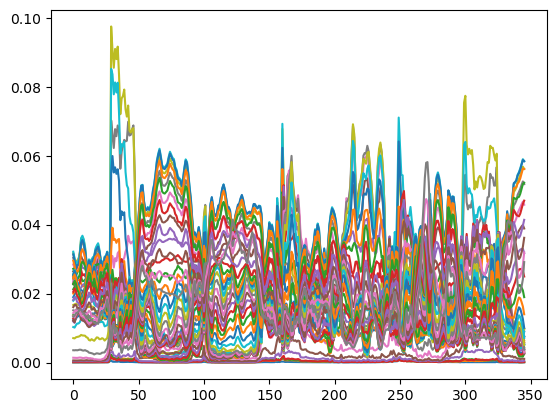

In [204]:
clean_feature_obs=slidingObsWindow(clean_features,120,3,"clean_features")
clean_periodicity_features = extractPeriodicityFeatures(".","clean_features_obs",len(clean_feature_obs),[120])
np.savetxt("clean_obs_per_features.dat",clean_periodicity_features,fmt="%f")
plt.plot(clean_periodicity_features)
plt.show()

[23.8        25.73333333 25.93333333 ...  2.13333333  8.13333333
 14.        ]
[2.38000000e+01 3.23780000e+03 2.44666667e+01 6.60651333e+04
 1.40000000e+01 8.03000000e+02 1.40000000e+01 3.29700000e+03
 3.42640725e+01 3.93062377e+03 3.47541205e+01 2.13442892e+05
 2.40366869e+00 1.01955569e+00 2.32674293e+00 3.45719968e+00
 2.70000000e+01 4.80000000e+01 7.64000000e+01 1.13360000e+02
 6.32550000e+03 8.32160000e+03 9.65040000e+03 1.14261600e+04
 2.90000000e+01 5.04000000e+01 7.95000000e+01 1.15200000e+02
 2.02495000e+04 3.34864000e+04 2.85279500e+05 6.32235200e+05]
AA
[[4.36000000e+01 2.94360000e+03 6.02666667e+01 ... 4.14731000e+05
  5.89377100e+05 6.47440840e+05]
 [4.00000000e+00 1.88533333e+02 5.66666667e+00 ... 3.74000000e+02
  5.50808000e+04 1.31670320e+05]
 [4.00000000e-01 3.02666667e+01 3.33333333e-01 ... 2.40000000e+01
  1.40200000e+02 2.80480000e+02]
 ...
 [1.91066667e+02 1.12388000e+04 4.46466667e+02 ... 7.63795400e+05
  7.83250000e+05 7.84942600e+05]
 [1.51666667e+02 9.13673333e

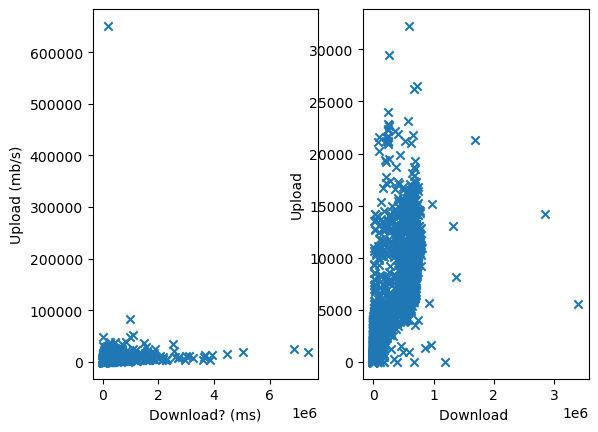

In [247]:
## up_pack (0:media 1:mediana 2:std 3:skew 4:75p 5:90p 6:95p 7:98p //8:len(silence) 9:mean_silence 10:std_silence 11:len(activity) 12:mean_act 13:std_act) ) up_bytes

# 4 colunas (2*up+2*down) * (8 features + 6 do silence^(3*2)) 
#            media mediana std skew 75p 90p 95p 98p
# up_pack     0      1       2   3   4  5   6   7 
# up_bytes    8      9      10  11  12  13  14  15
#down_pack   16      17     18  19  20  21  22  23
#down_byte   24      25     26  27  28  29  30  31


# which features to relate?
# or metrics

# upload/download
plt.subplot(1,2,1)
plt.scatter(clean_data[:, 4], clean_data[:, 2], marker="x")
plt.xlabel("Download? (ms)")
plt.ylabel("Upload (mb/s)")

plt.subplot(1,2,2)
plt.scatter(infected_data[:, 4], infected_data[:, 2], marker="x")
plt.xlabel("Download ")
plt.ylabel("Upload")


print("AA")
print(infected_features)

Text(0.5, 1.0, 'Download')

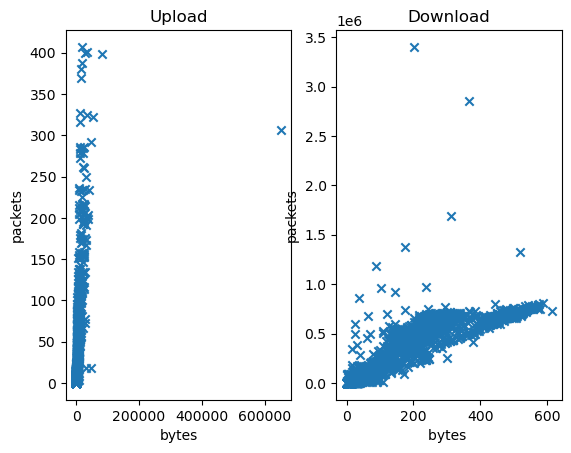

In [219]:
# byte/packet ratio


plt.subplot(1,2,1)
plt.scatter(clean_data[:, 2], clean_data[:,1], marker="x")
plt.xlabel("bytes")
plt.ylabel("packets")
plt.title("Upload")

plt.subplot(1,2,2)
plt.scatter(infected_data[:, 3], infected_data[:, 4], marker="x")
plt.xlabel("bytes ")
plt.ylabel("packets")

plt.title("Download")



Text(0, 0.5, 'bytes')

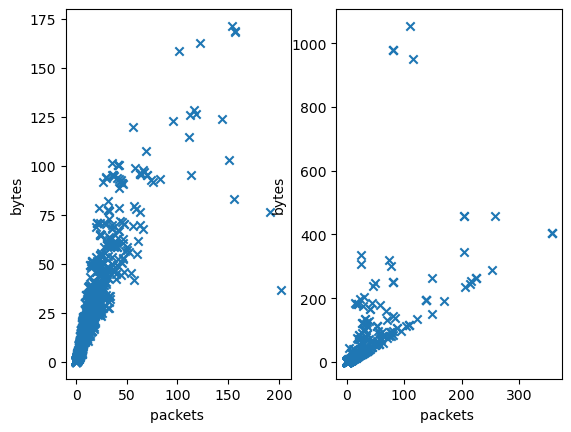

In [227]:
# 4 colunas (2*up+2*down) * (8 features + 6 do silence^(3*2)) 
#            media mediana std skew 75p 90p 95p 98p
# up_pack     0      1       2   3   4  5   6   7 
# up_bytes    8      9      10  11  12  13  14  15
#down_pack   16      17     18  19  20  21  22  23
#down_byte   24      25     26  27  28  29  30  31



plt.subplot(1,2,1)

plt.scatter(clean_features[:, 0], clean_features[:, 8], marker="x")
plt.xlabel("packets ")
plt.ylabel("bytes")


plt.subplot(1,2,2)

plt.scatter(clean_features[:, 16], clean_features[:, 24], marker="x")
plt.xlabel("packets ")
plt.ylabel("bytes")


Text(0, 0.5, 'bytes')

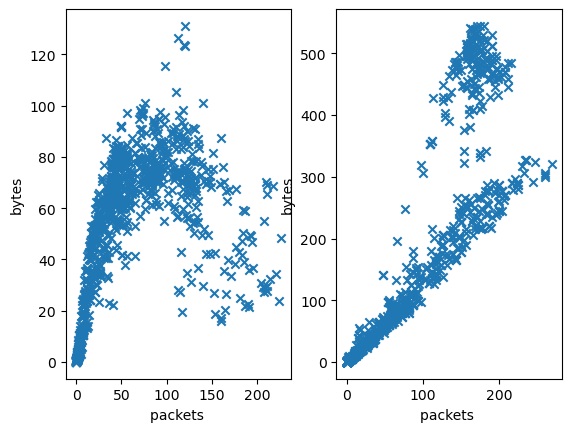

In [226]:

# averages of bytes over packets


plt.subplot(1,2,1)

plt.scatter(infected_features[:, 0], infected_features[:, 8], marker="x")
plt.xlabel("packets ")
plt.ylabel("bytes")


plt.subplot(1,2,2)

plt.scatter(infected_features[:, 16], infected_features[:, 24], marker="x")
plt.xlabel("packets ")
plt.ylabel("bytes")

[27.  27.  27.  ...  2.5  9.5 26. ]


(array([0.02743593, 0.00520639, 0.00353918, 0.00298344, 0.0025447 ,
        0.00116998, 0.00111148, 0.00122847, 0.00070199, 0.00093598,
        0.00061424, 0.00014625, 0.00043874, 0.00046799, 0.000234  ,
        0.00026324, 0.        , 0.        , 0.0001755 , 0.00014625]),
 array([  0.   ,  20.266,  40.532,  60.798,  81.064, 101.33 , 121.596,
        141.862, 162.128, 182.394, 202.66 , 222.926, 243.192, 263.458,
        283.724, 303.99 , 324.256, 344.522, 364.788, 385.054, 405.32 ]),
 <BarContainer object of 20 artists>)

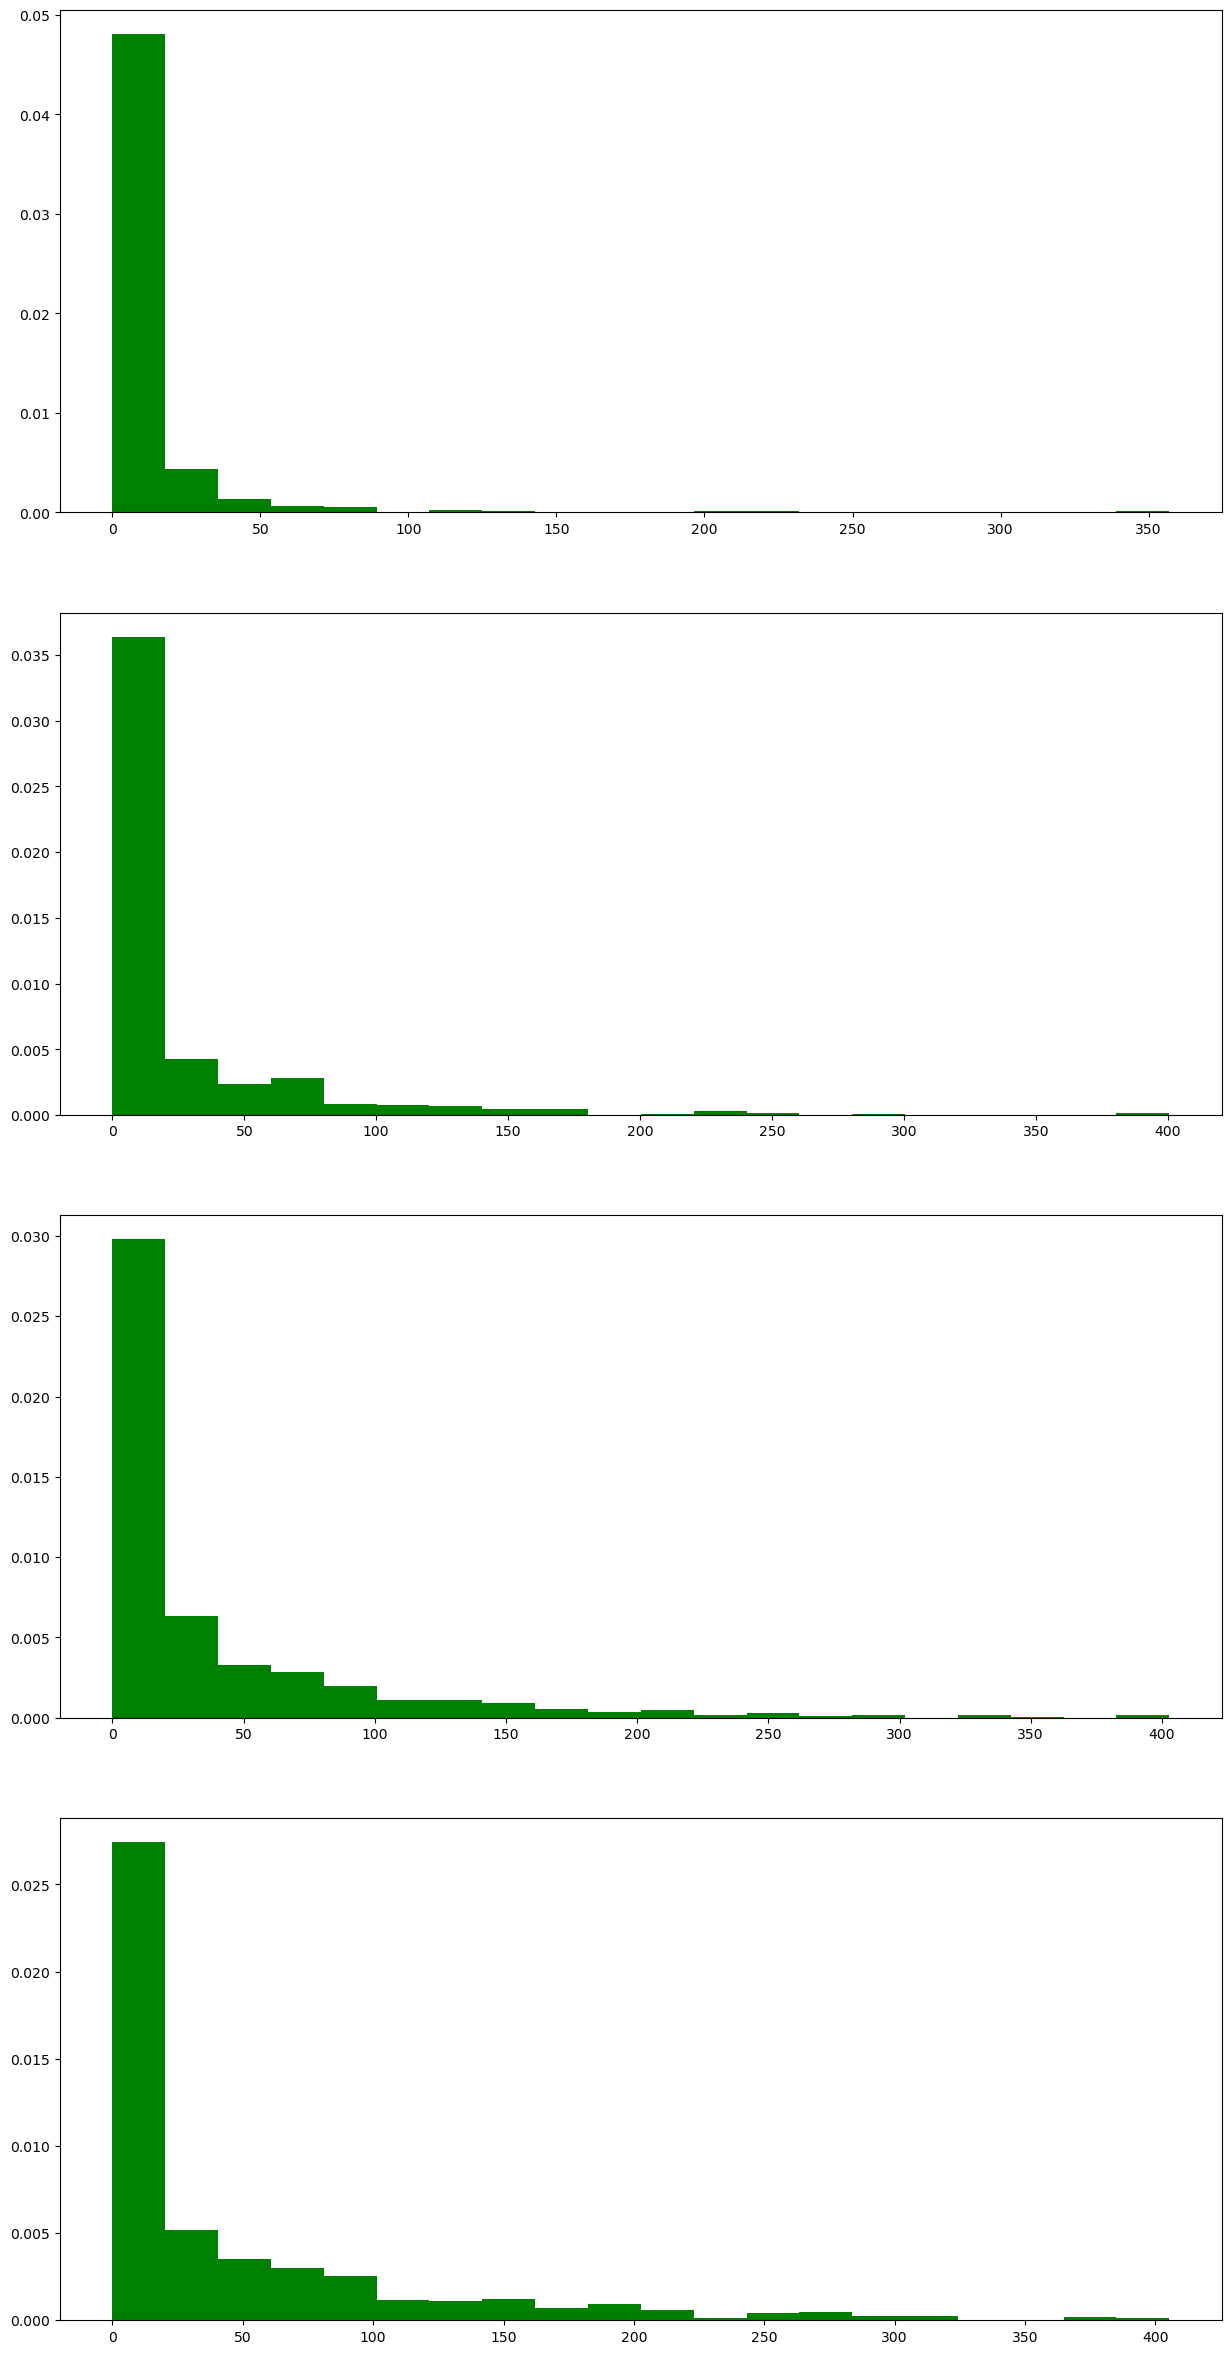

In [265]:
#12-15

# 4 colunas (2*up+2*down) * (8 features + 6 do silence^(3*2)) 
#            media mediana std skew 75p 90p 95p 98p
# up_pack     0      1       2   3   4  5   6   7 
# up_bytes    8      9      10  11  12  13  14  15
#down_pack   16      17     18  19  20  21  22  23
#down_byte   24      25     26  27  28  29  30  31


print(clean_features[:,16])
plt.figure(figsize=(15,30))
plt.subplot(4,1,1)
plt.hist(clean_features[:,16],20,density=1,color='g')


plt.subplot(4,1,2)
plt.hist(clean_features[:,17],20,density=1,color='g')


plt.subplot(4,1,3)
plt.hist(clean_features[:,18],20,density=1,color='g')


plt.subplot(4,1,4)
plt.hist(clean_features[:,19],20,density=1,color='g')



(array([0.00989834, 0.00206616, 0.0007688 , 0.00100905, 0.0011532 ,
        0.00120125, 0.00091295, 0.00144151, 0.00331546, 0.00711143,
        0.00677508, 0.00619847, 0.00629457, 0.00350766, 0.00216226,
        0.00043245, 0.00100905, 0.00014415, 0.        , 0.00024025]),
 array([  0.   ,  17.972,  35.944,  53.916,  71.888,  89.86 , 107.832,
        125.804, 143.776, 161.748, 179.72 , 197.692, 215.664, 233.636,
        251.608, 269.58 , 287.552, 305.524, 323.496, 341.468, 359.44 ]),
 <BarContainer object of 20 artists>)

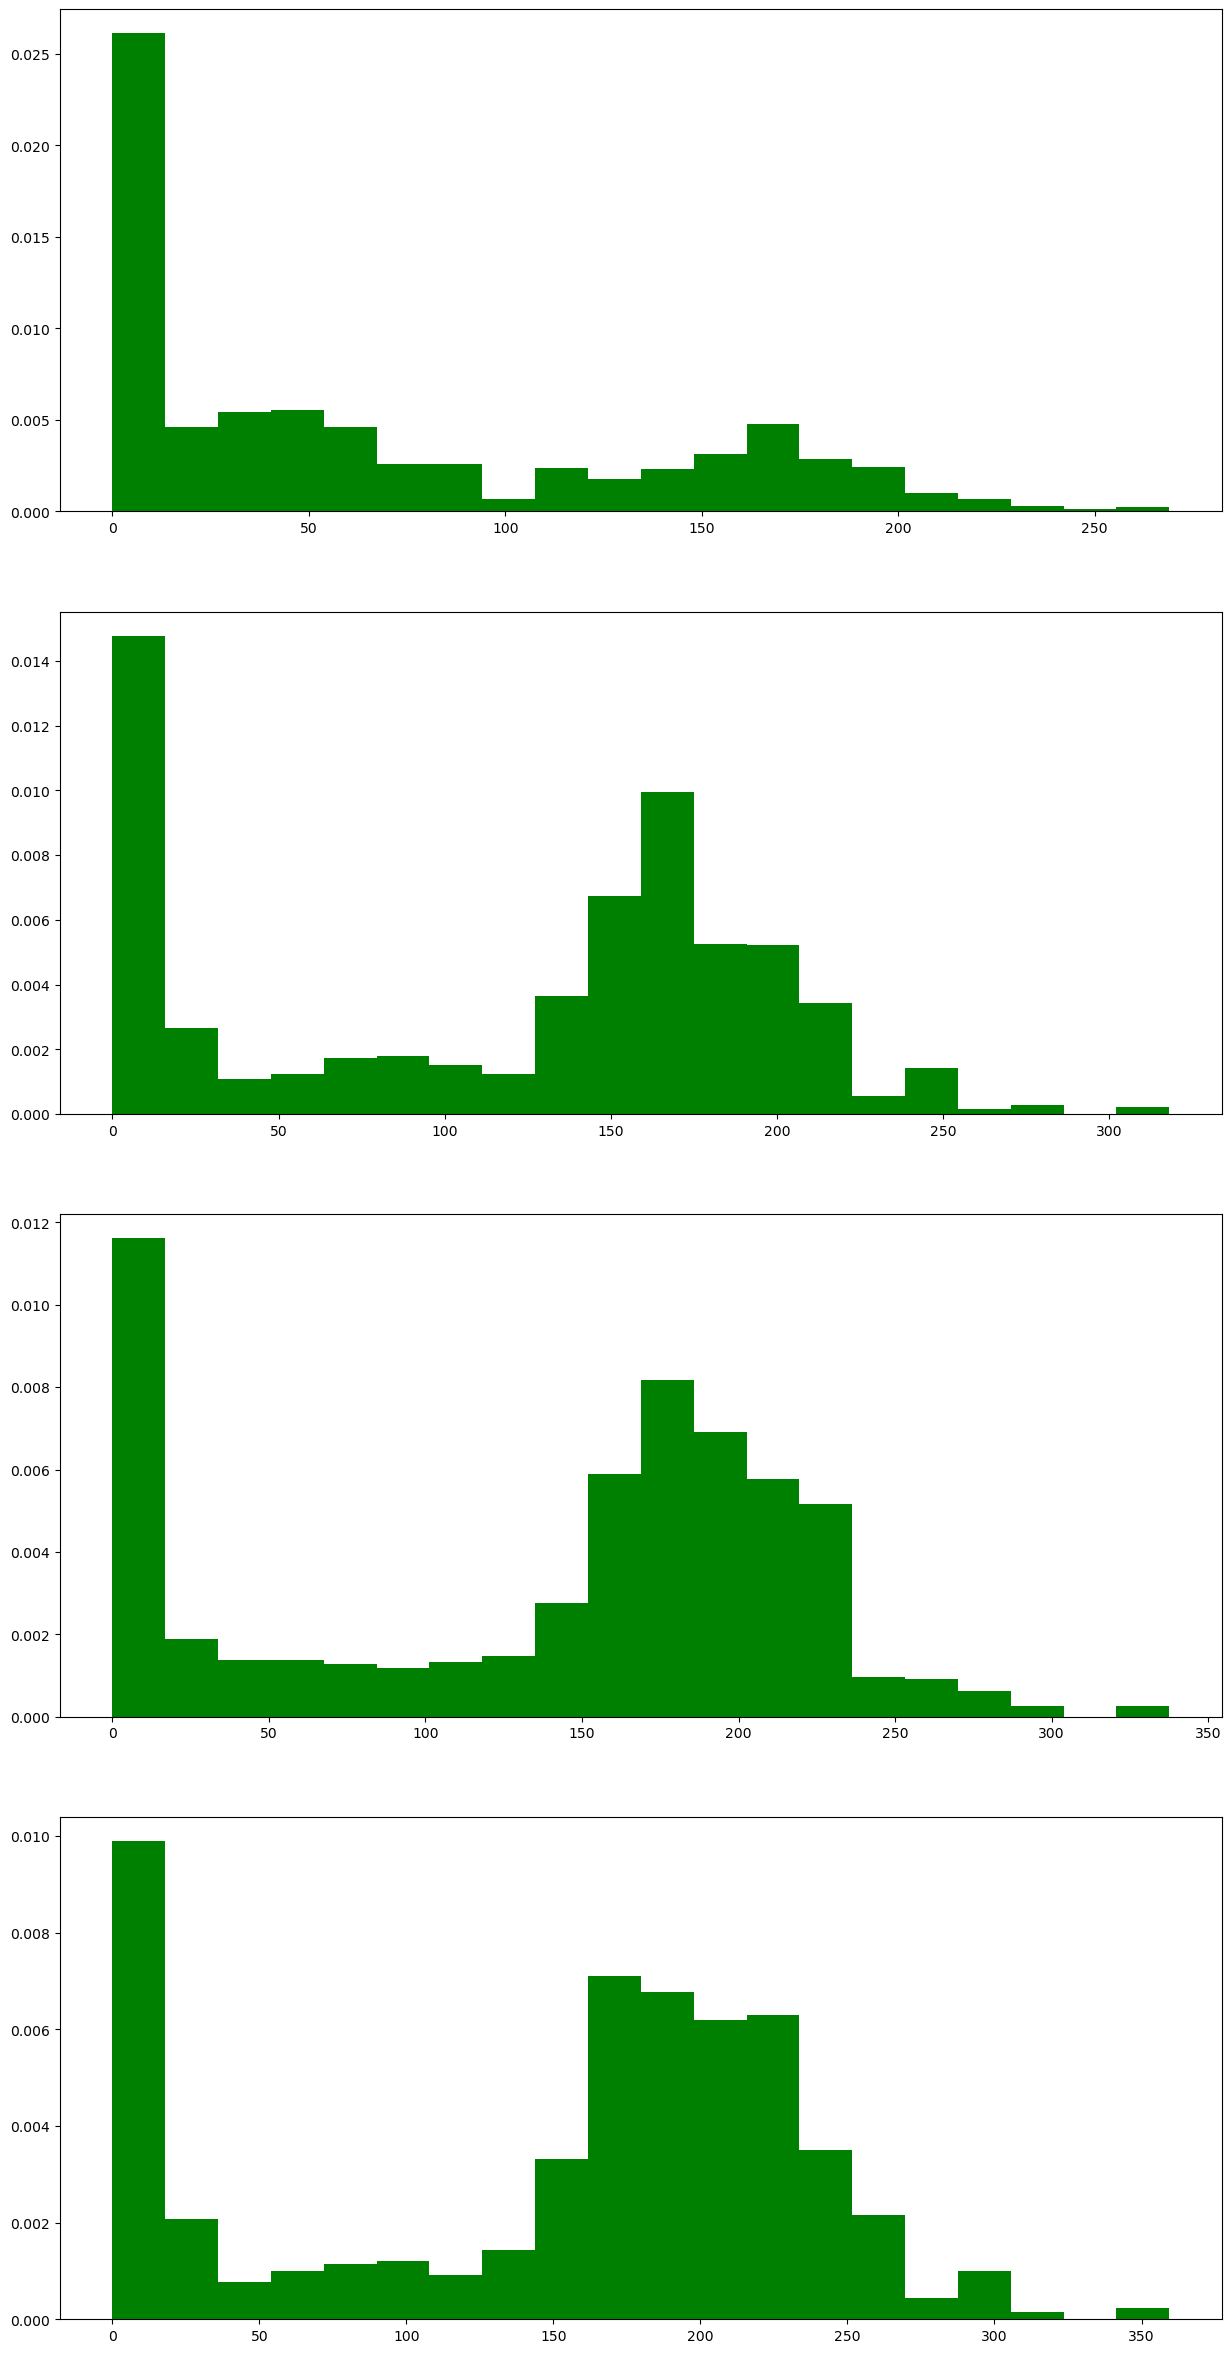

In [266]:
plt.figure(figsize=(15,30))
plt.subplot(4,1,1)
plt.hist(infected_features[:,16],20,density=1,color='g')


plt.subplot(4,1,2)
plt.hist(infected_features[:,17],20,density=1,color='g')


plt.subplot(4,1,3)
plt.hist(infected_features[:,18],20,density=1,color='g')


plt.subplot(4,1,4)
plt.hist(infected_features[:,19],20,density=1,color='g')



In [293]:


Xtrain=np.column_stack((clean_features[:,0],clean_features[:,8]))


Xtest = np.column_stack((infected_features[:,0],infected_features[:,8]))


Xtrain_down = np.column_stack((clean_features[:,16],clean_features[:,24]))
Xtest_down = np.column_stack((infected_features[:,16],infected_features[:,24]))


[[1.33333333e-01 4.98887652e-01]
 [1.33333333e-01 4.98887652e-01]
 [2.40000000e+00 8.46010244e+00]
 ...
 [1.91066667e+02 3.57518609e+01]
 [1.51666667e+02 8.16183531e+01]
 [1.26466667e+02 7.83767539e+01]]


[23.8        25.73333333 25.93333333 ...  2.13333333  8.13333333
 14.        ]


Text(0, 0.5, 'Avg Packets')

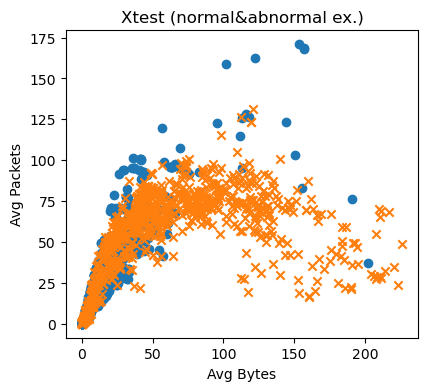

In [344]:
plt.figure(figsize=(10,4))


print(Xtrain[:,0])
plt.subplot(1, 2, 1)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], marker="o")
plt.title("Xtrain (only normal ex.)")
plt.xlabel("Avg Bytes")
plt.ylabel("Avg Packets")



plt.scatter(Xtest[:, 0], Xtest[:, 1], marker="x")
plt.title("Xtest (normal&abnormal ex.)")
plt.xlabel("Avg Bytes")
plt.ylabel("Avg Packets")




Text(0, 0.5, 'Avg Packets')

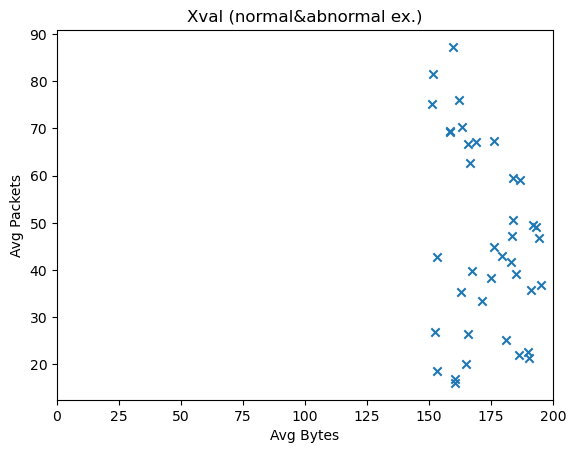

In [341]:


Xval = np.column_stack((infected_features[:,0],infected_features[:,8]))

new_xval = np.array([(x[0],x[1]) for x in Xval if x[0]>150])


plt.scatter(new_xval[:, 0], new_xval[:, 1], marker="x")
plt.title("Xval (normal&abnormal ex.)")
plt.xlim(0,200)



plt.xlabel("Avg Bytes")
plt.ylabel("Avg Packets")

Xval = new_xval

[23.8        25.73333333 25.93333333 ...  2.13333333  8.13333333
 14.        ]


Text(0, 0.5, 'Avg Packets')

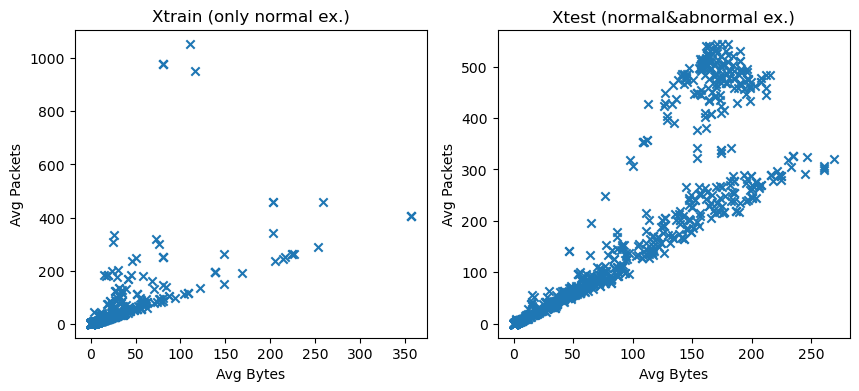

In [301]:
plt.figure(figsize=(10,4))


print(Xtrain[:,0])
plt.subplot(1, 2, 1)
plt.scatter(Xtrain_down[:, 0], Xtrain_down[:, 1], marker="x")
plt.title("Xtrain (only normal ex.)")
plt.xlabel("Avg Bytes")
plt.ylabel("Avg Packets")



plt.subplot(1, 2, 2)
plt.scatter(Xtest_down[:, 0], Xtest_down[:, 1], marker="x")
plt.title("Xtest (normal&abnormal ex.)")
plt.xlabel("Avg Bytes")
plt.ylabel("Avg Packets")

In [288]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    # number of examples in X
    m = X.shape[0]
    
    # compute mean
    mu = np.mean(X, axis=0)
     
    # compute variance =sigma^2
    sigma2 = 1/m * np.sum((X - mu)**2,axis=0)
    
    return mu,sigma2

def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate Gaussian distribution.
    """
    n= n = X.shape[1] #number of features 
    sigma_diag=np.diag(sigma2)  #Diagonal matrix (features are independent !!!!)
    X = X - mu.T
    p = 1/((2*np.pi)**(n/2)*(np.linalg.det(sigma_diag)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma_diag) * X,axis=1))
    return p

def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers
    """
    best_epi = 0
    best_F1 = 0
    
    #range of threshold values to decide the best one. 
    stepsize = (max(pval) -min(pval))/1000
    epi_range = np.arange(pval.min(),pval.max(),stepsize)
    for epi in epi_range:
        predictions = (pval<epi)[:,np.newaxis]
        
        #compute true positive (TP)
        tp = np.sum(predictions[yval==1]==1)
        tn = np.sum(predictions[yval==0]==0)
        
        #compute false positive (FP)
        fp = np.sum(predictions[yval==0]==1)
        
        #compute false negative 
        fn = np.sum(predictions[yval==1]==0)
        
        # Other way
        #tn, fp, fn, tp = confusion_matrix(yval, predictions).ravel()
        
        try:
        # compute precision, recall and F1
            prec = tp/(tp+fp)
            
            #compute recall and F1
            rec = tp/(tp+fn)
            #compute  F1
            F1 = (2*prec*rec)/(prec+rec) 
        
            if F1 > best_F1:
                best_F1 =F1
                best_epi = epi
            
        except ZeroDivisionError:
                print('Warning dividing by zero!!')  
        
    return best_epi, best_F1


def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l



In [289]:
mu, sigma2 = estimateGaussian(Xtrain)
print("mu: ", mu)
print("sigma2: ", sigma2)

mu:  [ 9.72902588 15.95796882]
sigma2:  [317.19503117 553.9177683 ]


In [292]:
p = multivariateGaussian(Xtest, mu, sigma2)
pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)


outl = (p < epsilon)
listOfOutliers=findIndices(outl)
count_outliers = len(listOfOutliers)
print('\n\nNumber of outliers (Xtest):', count_outliers)  #ANSWER: 6 
print('\n',listOfOutliers)

NameError: name 'epsilon' is not defined